In [1]:
#needed after restructuring of directory
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
# change directory to src so that we can import functions
os.chdir(os.path.join("..","..",".."))
from functions import *
# back to repo root
os.chdir("..")

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#importing csv fight data and saving as dataframes
ufc_fights = pd.read_csv('src/models/buildingMLModel/data/processed/ufc_fights.csv',low_memory=False)
ufcfighterscrap =pd.read_csv('src/models/buildingMLModel/data/processed/fighter_stats.csv',sep=',',low_memory=False)
#cleaning the methods column for method prediction (counting split decisions as decisions)
ufc_fights['method'] = clean_method_vect(ufc_fights['method'])
ufc_fights['method'].unique()
#getting rid of rows with incomplete or useless data
#fights with outcome "Win" or "Loss" (no "Draw")
draw_mask=ufc_fights['result'] != 'D' 
#fights where the method of victory is TKO/SUB/DEC (no bullshit)
method_mask=(ufc_fights['method']=='DEC')|(ufc_fights['method']=='SUB')|(ufc_fights['method']=='KO/TKO')
#fights where age is known
age_mask=(ufc_fights['fighter_age']!='unknown')&(ufc_fights['opponent_age']!='unknown')
#fights where height reach is known
height_mask=(ufc_fights['fighter_height']!='unknown')&(ufc_fights['opponent_height']!='unknown')
reach_mask=(ufc_fights['fighter_reach']!='unknown')&(ufc_fights['opponent_reach']!='unknown')
#fights where number of wins is known
wins_mask=(ufc_fights['fighter_wins'] != 'unknown' )& (ufc_fights['opponent_wins'] != 'unknown')
#fights where both fighters have strike statistics (gets rid of UFC debuts)
strikes_mask=(ufc_fights['fighter_inf_sig_strikes_attempts_avg'] != 0)&(ufc_fights['opponent_inf_sig_strikes_attempts_avg'] != 0)
#includes only the fights satisfying these conditions
ufc_fights=ufc_fights[draw_mask&method_mask&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]

record_statistics=[u'fighter_wins', u'fighter_losses',u'fighter_L5Y_wins',u'fighter_L5Y_losses', u'fighter_L2Y_wins', u'fighter_L2Y_losses', u'fighter_ko_wins',u'fighter_ko_losses',u'fighter_L5Y_ko_wins',u'fighter_L5Y_ko_losses',u'fighter_L2Y_ko_wins', u'fighter_L2Y_ko_losses',u'fighter_sub_wins',u'fighter_sub_losses',u'fighter_L5Y_sub_wins', u'fighter_L5Y_sub_losses', u'fighter_L2Y_sub_wins', u'fighter_L2Y_sub_losses',u'opponent_wins', u'opponent_losses',u'opponent_L5Y_wins', u'opponent_L5Y_losses', u'opponent_L2Y_wins', u'opponent_L2Y_losses',  u'opponent_ko_wins', u'opponent_ko_losses', u'opponent_L5Y_ko_wins', u'opponent_L5Y_ko_losses', u'opponent_L2Y_ko_wins', u'opponent_L2Y_ko_losses', u'opponent_sub_wins', u'opponent_sub_losses',u'opponent_L5Y_sub_wins',  u'opponent_L5Y_sub_losses', u'opponent_L2Y_sub_wins', u'opponent_L2Y_sub_losses']
physical_stats=[ u'fighter_age',u'fighter_height',    u'fighter_reach',  u'opponent_age',  u'opponent_height', u'opponent_reach']
punch_statistics=[ u'fighter_inf_knockdowns_avg',u'fighter_inf_pass_avg',u'fighter_inf_reversals_avg',u'fighter_inf_sub_attempts_avg',u'fighter_inf_takedowns_landed_avg',u'fighter_inf_takedowns_attempts_avg',u'fighter_inf_sig_strikes_landed_avg',u'fighter_inf_sig_strikes_attempts_avg',u'fighter_inf_total_strikes_landed_avg',u'fighter_inf_total_strikes_attempts_avg',u'fighter_inf_head_strikes_landed_avg',u'fighter_inf_head_strikes_attempts_avg',u'fighter_inf_body_strikes_landed_avg',u'fighter_inf_body_strikes_attempts_avg',u'fighter_inf_leg_strikes_landed_avg',u'fighter_inf_leg_strikes_attempts_avg',u'fighter_inf_distance_strikes_landed_avg',u'fighter_inf_distance_strikes_attempts_avg',u'fighter_inf_clinch_strikes_landed_avg',u'fighter_inf_clinch_strikes_attempts_avg',u'fighter_inf_ground_strikes_landed_avg',u'fighter_inf_ground_strikes_attempts_avg',u'fighter_abs_knockdowns_avg',u'fighter_abs_pass_avg',u'fighter_abs_reversals_avg',u'fighter_abs_sub_attempts_avg',u'fighter_abs_takedowns_landed_avg',u'fighter_abs_takedowns_attempts_avg',u'fighter_abs_sig_strikes_landed_avg',u'fighter_abs_sig_strikes_attempts_avg',u'fighter_abs_total_strikes_landed_avg',u'fighter_abs_total_strikes_attempts_avg',u'fighter_abs_head_strikes_landed_avg',u'fighter_abs_head_strikes_attempts_avg',u'fighter_abs_body_strikes_landed_avg',u'fighter_abs_body_strikes_attempts_avg',u'fighter_abs_leg_strikes_landed_avg',u'fighter_abs_leg_strikes_attempts_avg',u'fighter_abs_distance_strikes_landed_avg',u'fighter_abs_distance_strikes_attempts_avg',u'fighter_abs_clinch_strikes_landed_avg',u'fighter_abs_clinch_strikes_attempts_avg',u'fighter_abs_ground_strikes_landed_avg',u'fighter_abs_ground_strikes_attempts_avg',u'opponent_inf_knockdowns_avg',u'opponent_inf_pass_avg',u'opponent_inf_reversals_avg',u'opponent_inf_sub_attempts_avg',u'opponent_inf_takedowns_landed_avg',u'opponent_inf_takedowns_attempts_avg',u'opponent_inf_sig_strikes_landed_avg',u'opponent_inf_sig_strikes_attempts_avg',u'opponent_inf_total_strikes_landed_avg',u'opponent_inf_total_strikes_attempts_avg',u'opponent_inf_head_strikes_landed_avg',u'opponent_inf_head_strikes_attempts_avg',u'opponent_inf_body_strikes_landed_avg',u'opponent_inf_body_strikes_attempts_avg',u'opponent_inf_leg_strikes_landed_avg',u'opponent_inf_leg_strikes_attempts_avg',u'opponent_inf_distance_strikes_landed_avg',u'opponent_inf_distance_strikes_attempts_avg',u'opponent_inf_clinch_strikes_landed_avg',u'opponent_inf_clinch_strikes_attempts_avg',u'opponent_inf_ground_strikes_landed_avg',u'opponent_inf_ground_strikes_attempts_avg',u'opponent_abs_knockdowns_avg',u'opponent_abs_pass_avg',u'opponent_abs_reversals_avg',u'opponent_abs_sub_attempts_avg',u'opponent_abs_takedowns_landed_avg',u'opponent_abs_takedowns_attempts_avg',u'opponent_abs_sig_strikes_landed_avg',u'opponent_abs_sig_strikes_attempts_avg',u'opponent_abs_total_strikes_landed_avg',u'opponent_abs_total_strikes_attempts_avg',u'opponent_abs_head_strikes_landed_avg',u'opponent_abs_head_strikes_attempts_avg',u'opponent_abs_body_strikes_landed_avg',u'opponent_abs_body_strikes_attempts_avg',u'opponent_abs_leg_strikes_landed_avg',u'opponent_abs_leg_strikes_attempts_avg',u'opponent_abs_distance_strikes_landed_avg',u'opponent_abs_distance_strikes_attempts_avg',u'opponent_abs_clinch_strikes_landed_avg',u'opponent_abs_clinch_strikes_attempts_avg',u'opponent_abs_ground_strikes_landed_avg',u'opponent_abs_ground_strikes_attempts_avg']

#here is the version of punch stats geared for comparing fighter_inf to opponent_abs

fight_math_stats=['4-fighter_score_diff','9-fighter_score_diff','15-fighter_score_diff','1-fight_math','6-fight_math',]

#adding record differences to ufc_fights
record_statistics_diff = []
half_length=int(len(record_statistics)/2)
for i in range(half_length):
    ufc_fights[record_statistics[i]+'_diff_2']=ufc_fights[record_statistics[i]]-ufc_fights[record_statistics[i+half_length]]
    record_statistics_diff.append(record_statistics[i]+'_diff_2')
    
#lets try and improve the greedy algorithm by considering differences. Lets start by replacing height and reach by their differences
ufc_fights['height_diff']=ufc_fights['fighter_height'].apply(float)-ufc_fights['opponent_height'].apply(float)
ufc_fights['reach_diff']=ufc_fights['fighter_reach'].apply(float)-ufc_fights['opponent_reach'].apply(float)
physical_stats_diff = [ 'fighter_age','opponent_age', 'height_diff', 'reach_diff']

#adding punch differences to ufc_fights
punch_statistics_diff = []
half_length=int(len(punch_statistics)/2)
for i in range(half_length):
    ufc_fights[punch_statistics[i]+'_diff_2']=ufc_fights[punch_statistics[i]]-ufc_fights[punch_statistics[i+half_length]]
    punch_statistics_diff.append(punch_statistics[i]+'_diff_2')
    
possible_stats =record_statistics_diff+physical_stats_diff+punch_statistics_diff+fight_math_stats
 
ufc_fights['fighter_age'] = ufc_fights['fighter_age'].apply(float)
ufc_fights['opponent_age'] = ufc_fights['opponent_age'].apply(float)

In [47]:
ufc_fights = ufc_fights.dropna(subset=possible_stats)

In [48]:
# Create tensors to input into neural net
Xr=ufc_fights[possible_stats]
yr = ufc_fights['method'].to_numpy().reshape(-1,1)

# Normalize Xr to have mean 0 and std 1
Xr_mean = Xr.mean()
Xr_std = Xr.std()
Xr_normalized=(Xr-Xr_mean)/Xr_std

# One-hot encode yr so 
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False).fit(yr)
yr_onehot = ohe.transform(yr)

# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
Xr_normalized = torch.tensor(Xr_normalized.values, dtype=torch.float32)
yr_onehot = torch.tensor(yr_onehot, dtype=torch.float32)

In [50]:
# shows which labels correspond to which methods
method_0 = ohe.inverse_transform(np.array([[1,0,0]]))[0,0]
method_1 = ohe.inverse_transform(np.array([[0,1,0]]))[0,0]
method_2 = ohe.inverse_transform(np.array([[0,0,1]]))[0,0]
print(f'label: 0 <-----> method:    {method_0} <-----> [1,0,0]')
print(f'label: 1 <-----> method: {method_1} <-----> [0,1,0]')
print(f'label: 2 <-----> method:    {method_2} <-----> [0,0,1]')

label: 0 <-----> method:    DEC <-----> [1,0,0]
label: 1 <-----> method: KO/TKO <-----> [0,1,0]
label: 2 <-----> method:    SUB <-----> [0,0,1]


In [62]:
Xr_normalized.shape, yr_onehot.shape

(torch.Size([4572, 71]), torch.Size([4572, 3]))

In [86]:
# Defining parameters
lr_ = 0.00005                    # learning rate (default: 1e-3)
betas_ = (0.9, 0.999)           # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
eps_ = 1e-08                    # term added to the denominator to improve numerical stability (default: 1e-8)
weight_decay_ = 0.01               # weight decay (L2 penalty) (default: 0)
num_neurons_ = 80              # number of neurons in hidden layer (default: 100)

In [87]:
# using https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/
# but trying to get logsoftmax to work
class Multiclass(nn.Module):
    def __init__(self, num_features, num_neurons, num_classes):
        super().__init__()
        self.hidden = nn.Linear(num_features, num_neurons)
        self.relu = nn.ReLU()
        self.output = nn.Linear(num_neurons, num_classes)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.softmax(self.output(x))
        return x
    
# defining the learning model
model = Multiclass(Xr_normalized.shape[1], num_neurons_, yr_onehot.shape[1])

# choosing NLLLoss since we are using LogSoftmax as our output activation
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr_, betas=betas_, eps=eps_, weight_decay=weight_decay_)

In [88]:
yr_labels = torch.argmax(yr_onehot, dim=1)
yr_labels

tensor([2, 1, 2,  ..., 0, 2, 1])

In [89]:
# real training loop
import copy
import tqdm
import numpy as np

# split
X_train, X_test, y_train, y_test = train_test_split(Xr_normalized, yr_onehot, train_size=0.7, shuffle=True)

n_epochs = 500
batch_size = 250
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            y_batch_labeled = torch.argmax(y_batch, 1)
            loss = loss_fn(y_pred, y_batch_labeled)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, torch.argmax(y_test, 1))
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: negative log likelihood loss={ce}, Accuracy={acc}")
    
model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 196.73batch/s, acc=0.36, loss=1.1]  


Epoch 0 validation: negative log likelihood loss=1.1065177917480469, Accuracy=0.3338192403316498


Epoch 1: 100%|██████████| 12/12 [00:00<00:00, 169.02batch/s, acc=0.372, loss=1.09]


Epoch 1 validation: negative log likelihood loss=1.1025707721710205, Accuracy=0.3352769613265991


Epoch 2: 100%|██████████| 12/12 [00:00<00:00, 166.67batch/s, acc=0.368, loss=1.09]


Epoch 2 validation: negative log likelihood loss=1.0988601446151733, Accuracy=0.3469387888908386


Epoch 3: 100%|██████████| 12/12 [00:00<00:00, 176.48batch/s, acc=0.38, loss=1.08]


Epoch 3 validation: negative log likelihood loss=1.0953882932662964, Accuracy=0.36297374963760376


Epoch 4: 100%|██████████| 12/12 [00:00<00:00, 148.16batch/s, acc=0.384, loss=1.08]


Epoch 4 validation: negative log likelihood loss=1.0921392440795898, Accuracy=0.3760932981967926


Epoch 5: 100%|██████████| 12/12 [00:00<00:00, 166.67batch/s, acc=0.392, loss=1.08]


Epoch 5 validation: negative log likelihood loss=1.0890984535217285, Accuracy=0.37973761558532715


Epoch 6: 100%|██████████| 12/12 [00:00<00:00, 169.02batch/s, acc=0.424, loss=1.07]


Epoch 6 validation: negative log likelihood loss=1.0862563848495483, Accuracy=0.3884839713573456


Epoch 7: 100%|██████████| 12/12 [00:00<00:00, 171.44batch/s, acc=0.44, loss=1.07] 


Epoch 7 validation: negative log likelihood loss=1.0836018323898315, Accuracy=0.39431485533714294


Epoch 8: 100%|██████████| 12/12 [00:00<00:00, 90.91batch/s, acc=0.452, loss=1.07] 


Epoch 8 validation: negative log likelihood loss=1.0811192989349365, Accuracy=0.397230327129364


Epoch 9: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.48, loss=1.06] 


Epoch 9 validation: negative log likelihood loss=1.0787979364395142, Accuracy=0.4052478075027466


Epoch 10: 100%|██████████| 12/12 [00:00<00:00, 171.43batch/s, acc=0.484, loss=1.06]


Epoch 10 validation: negative log likelihood loss=1.0766267776489258, Accuracy=0.4118075668811798


Epoch 11: 100%|██████████| 12/12 [00:00<00:00, 171.43batch/s, acc=0.484, loss=1.06]


Epoch 11 validation: negative log likelihood loss=1.0745974779129028, Accuracy=0.413994163274765


Epoch 12: 100%|██████████| 12/12 [00:00<00:00, 166.68batch/s, acc=0.476, loss=1.06]


Epoch 12 validation: negative log likelihood loss=1.072698950767517, Accuracy=0.42201167345046997


Epoch 13: 100%|██████████| 12/12 [00:00<00:00, 166.68batch/s, acc=0.484, loss=1.05]


Epoch 13 validation: negative log likelihood loss=1.070923089981079, Accuracy=0.4212827980518341


Epoch 14: 100%|██████████| 12/12 [00:00<00:00, 176.46batch/s, acc=0.5, loss=1.05]  


Epoch 14 validation: negative log likelihood loss=1.0692607164382935, Accuracy=0.41763848066329956


Epoch 15: 100%|██████████| 12/12 [00:00<00:00, 103.45batch/s, acc=0.492, loss=1.05]


Epoch 15 validation: negative log likelihood loss=1.067704200744629, Accuracy=0.4234693944454193


Epoch 16: 100%|██████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.484, loss=1.05]


Epoch 16 validation: negative log likelihood loss=1.0662449598312378, Accuracy=0.42711371183395386


Epoch 17: 100%|██████████| 12/12 [00:00<00:00, 157.91batch/s, acc=0.492, loss=1.05]


Epoch 17 validation: negative log likelihood loss=1.0648791790008545, Accuracy=0.4329445958137512


Epoch 18: 100%|██████████| 12/12 [00:00<00:00, 155.86batch/s, acc=0.488, loss=1.05]


Epoch 18 validation: negative log likelihood loss=1.063602089881897, Accuracy=0.43950438499450684


Epoch 19: 100%|██████████| 12/12 [00:00<00:00, 164.39batch/s, acc=0.492, loss=1.04]


Epoch 19 validation: negative log likelihood loss=1.0624048709869385, Accuracy=0.4453352689743042


Epoch 20: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.492, loss=1.04]


Epoch 20 validation: negative log likelihood loss=1.0612820386886597, Accuracy=0.4497084617614746


Epoch 21: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.472, loss=1.04]


Epoch 21 validation: negative log likelihood loss=1.0602302551269531, Accuracy=0.4518950581550598


Epoch 22: 100%|██████████| 12/12 [00:00<00:00, 155.86batch/s, acc=0.476, loss=1.04]


Epoch 22 validation: negative log likelihood loss=1.0592399835586548, Accuracy=0.4548105001449585


Epoch 23: 100%|██████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.488, loss=1.04]


Epoch 23 validation: negative log likelihood loss=1.05830979347229, Accuracy=0.45845481753349304


Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.5, loss=1.04]  


Epoch 24 validation: negative log likelihood loss=1.0574328899383545, Accuracy=0.4599125385284424


Epoch 25: 100%|██████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.5, loss=1.04]  


Epoch 25 validation: negative log likelihood loss=1.056604266166687, Accuracy=0.46064141392707825


Epoch 26: 100%|██████████| 12/12 [00:00<00:00, 81.63batch/s, acc=0.496, loss=1.04] 


Epoch 26 validation: negative log likelihood loss=1.0558204650878906, Accuracy=0.46282798051834106


Epoch 27: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.5, loss=1.04]  


Epoch 27 validation: negative log likelihood loss=1.055080533027649, Accuracy=0.4613702595233917


Epoch 28: 100%|██████████| 12/12 [00:00<00:00, 148.16batch/s, acc=0.508, loss=1.03]


Epoch 28 validation: negative log likelihood loss=1.054381012916565, Accuracy=0.46282798051834106


Epoch 29: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.508, loss=1.03]


Epoch 29 validation: negative log likelihood loss=1.0537201166152954, Accuracy=0.4642857015132904


Epoch 30: 100%|██████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.508, loss=1.03]


Epoch 30 validation: negative log likelihood loss=1.0530952215194702, Accuracy=0.4686588943004608


Epoch 31: 100%|██████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.508, loss=1.03]


Epoch 31 validation: negative log likelihood loss=1.0525051355361938, Accuracy=0.4664722979068756


Epoch 32: 100%|██████████| 12/12 [00:00<00:00, 160.01batch/s, acc=0.508, loss=1.03]


Epoch 32 validation: negative log likelihood loss=1.0519455671310425, Accuracy=0.4664722979068756


Epoch 33: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.512, loss=1.03]


Epoch 33 validation: negative log likelihood loss=1.051412582397461, Accuracy=0.4693877696990967


Epoch 34: 100%|██████████| 12/12 [00:00<00:00, 151.91batch/s, acc=0.508, loss=1.03]


Epoch 34 validation: negative log likelihood loss=1.050907015800476, Accuracy=0.4686588943004608


Epoch 35: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.508, loss=1.03]


Epoch 35 validation: negative log likelihood loss=1.0504237413406372, Accuracy=0.47011661529541016


Epoch 36: 100%|██████████| 12/12 [00:00<00:00, 151.91batch/s, acc=0.512, loss=1.03]


Epoch 36 validation: negative log likelihood loss=1.049963355064392, Accuracy=0.470845490694046


Epoch 37: 100%|██████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.512, loss=1.03]


Epoch 37 validation: negative log likelihood loss=1.0495245456695557, Accuracy=0.47011661529541016


Epoch 38: 100%|██████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.5, loss=1.03]  


Epoch 38 validation: negative log likelihood loss=1.0491039752960205, Accuracy=0.47303205728530884


Epoch 39: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.5, loss=1.03]  


Epoch 39 validation: negative log likelihood loss=1.0487027168273926, Accuracy=0.470845490694046


Epoch 40: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.496, loss=1.03]


Epoch 40 validation: negative log likelihood loss=1.0483161211013794, Accuracy=0.4737609326839447


Epoch 41: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.504, loss=1.03]


Epoch 41 validation: negative log likelihood loss=1.0479457378387451, Accuracy=0.4737609326839447


Epoch 42: 100%|██████████| 12/12 [00:00<00:00, 101.70batch/s, acc=0.504, loss=1.03]


Epoch 42 validation: negative log likelihood loss=1.0475940704345703, Accuracy=0.4737609326839447


Epoch 43: 100%|██████████| 12/12 [00:00<00:00, 122.46batch/s, acc=0.5, loss=1.03]  


Epoch 43 validation: negative log likelihood loss=1.047257900238037, Accuracy=0.47303205728530884


Epoch 44: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.5, loss=1.03]  


Epoch 44 validation: negative log likelihood loss=1.0469366312026978, Accuracy=0.4737609326839447


Epoch 45: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.5, loss=1.02] 


Epoch 45 validation: negative log likelihood loss=1.0466289520263672, Accuracy=0.47521865367889404


Epoch 46: 100%|██████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.5, loss=1.02]  


Epoch 46 validation: negative log likelihood loss=1.046331763267517, Accuracy=0.47521865367889404


Epoch 47: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.496, loss=1.02]


Epoch 47 validation: negative log likelihood loss=1.046046257019043, Accuracy=0.4759475290775299


Epoch 48: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.5, loss=1.02] 


Epoch 48 validation: negative log likelihood loss=1.0457713603973389, Accuracy=0.4759475290775299


Epoch 49: 100%|██████████| 12/12 [00:00<00:00, 129.04batch/s, acc=0.5, loss=1.02] 


Epoch 49 validation: negative log likelihood loss=1.045501708984375, Accuracy=0.4766763746738434


Epoch 50: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.5, loss=1.02] 


Epoch 50 validation: negative log likelihood loss=1.0452395677566528, Accuracy=0.4766763746738434


Epoch 51: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.504, loss=1.02]


Epoch 51 validation: negative log likelihood loss=1.0449883937835693, Accuracy=0.47740525007247925


Epoch 52: 100%|██████████| 12/12 [00:00<00:00, 125.00batch/s, acc=0.508, loss=1.02]


Epoch 52 validation: negative log likelihood loss=1.04474675655365, Accuracy=0.4781341254711151


Epoch 53: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.508, loss=1.02]


Epoch 53 validation: negative log likelihood loss=1.0445129871368408, Accuracy=0.47740525007247925


Epoch 54: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.508, loss=1.02]


Epoch 54 validation: negative log likelihood loss=1.0442856550216675, Accuracy=0.47740525007247925


Epoch 55: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.508, loss=1.02]


Epoch 55 validation: negative log likelihood loss=1.0440669059753418, Accuracy=0.47959184646606445


Epoch 56: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.508, loss=1.02]


Epoch 56 validation: negative log likelihood loss=1.0438557863235474, Accuracy=0.48032069206237793


Epoch 57: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.508, loss=1.02]


Epoch 57 validation: negative log likelihood loss=1.0436480045318604, Accuracy=0.4810495674610138


Epoch 58: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.508, loss=1.02]


Epoch 58 validation: negative log likelihood loss=1.043447494506836, Accuracy=0.4788629710674286


Epoch 59: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.508, loss=1.02]


Epoch 59 validation: negative log likelihood loss=1.0432528257369995, Accuracy=0.4781341254711151


Epoch 60: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.504, loss=1.02]


Epoch 60 validation: negative log likelihood loss=1.0430635213851929, Accuracy=0.4781341254711151


Epoch 61: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.5, loss=1.02]   


Epoch 61 validation: negative log likelihood loss=1.0428816080093384, Accuracy=0.47740525007247925


Epoch 62: 100%|██████████| 12/12 [00:00<00:00, 74.08batch/s, acc=0.504, loss=1.02] 


Epoch 62 validation: negative log likelihood loss=1.042704463005066, Accuracy=0.47740525007247925


Epoch 63: 100%|██████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.504, loss=1.02] 


Epoch 63 validation: negative log likelihood loss=1.0425305366516113, Accuracy=0.4781341254711151


Epoch 64: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.504, loss=1.02] 


Epoch 64 validation: negative log likelihood loss=1.0423628091812134, Accuracy=0.4788629710674286


Epoch 65: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.504, loss=1.02] 


Epoch 65 validation: negative log likelihood loss=1.042197585105896, Accuracy=0.4781341254711151


Epoch 66: 100%|██████████| 12/12 [00:00<00:00, 123.72batch/s, acc=0.504, loss=1.02] 


Epoch 66 validation: negative log likelihood loss=1.0420368909835815, Accuracy=0.4781341254711151


Epoch 67: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.504, loss=1.02] 


Epoch 67 validation: negative log likelihood loss=1.041883111000061, Accuracy=0.4781341254711151


Epoch 68: 100%|██████████| 12/12 [00:00<00:00, 129.03batch/s, acc=0.504, loss=1.02] 


Epoch 68 validation: negative log likelihood loss=1.041733980178833, Accuracy=0.47740525007247925


Epoch 69: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.504, loss=1.02] 


Epoch 69 validation: negative log likelihood loss=1.041589379310608, Accuracy=0.47740525007247925


Epoch 70: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.504, loss=1.02] 


Epoch 70 validation: negative log likelihood loss=1.0414464473724365, Accuracy=0.47740525007247925


Epoch 71: 100%|██████████| 12/12 [00:00<00:00, 139.55batch/s, acc=0.504, loss=1.02] 


Epoch 71 validation: negative log likelihood loss=1.041308045387268, Accuracy=0.47740525007247925


Epoch 72: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.504, loss=1.02] 


Epoch 72 validation: negative log likelihood loss=1.041174054145813, Accuracy=0.47740525007247925


Epoch 73: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.504, loss=1.02] 


Epoch 73 validation: negative log likelihood loss=1.0410430431365967, Accuracy=0.47740525007247925


Epoch 74: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.504, loss=1.02] 


Epoch 74 validation: negative log likelihood loss=1.0409154891967773, Accuracy=0.4766763746738434


Epoch 75: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.504, loss=1.02] 


Epoch 75 validation: negative log likelihood loss=1.0407897233963013, Accuracy=0.4766763746738434


Epoch 76: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.504, loss=1.02] 


Epoch 76 validation: negative log likelihood loss=1.0406653881072998, Accuracy=0.4766763746738434


Epoch 77: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.504, loss=1.01] 


Epoch 77 validation: negative log likelihood loss=1.0405447483062744, Accuracy=0.4766763746738434


Epoch 78: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.504, loss=1.01] 


Epoch 78 validation: negative log likelihood loss=1.0404267311096191, Accuracy=0.47740525007247925


Epoch 79: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.512, loss=1.01] 


Epoch 79 validation: negative log likelihood loss=1.0403108596801758, Accuracy=0.4781341254711151


Epoch 80: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.512, loss=1.01] 


Epoch 80 validation: negative log likelihood loss=1.0401973724365234, Accuracy=0.4781341254711151


Epoch 81: 100%|██████████| 12/12 [00:00<00:00, 117.65batch/s, acc=0.512, loss=1.01]


Epoch 81 validation: negative log likelihood loss=1.0400856733322144, Accuracy=0.4781341254711151


Epoch 82: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.512, loss=1.01]


Epoch 82 validation: negative log likelihood loss=1.0399757623672485, Accuracy=0.4781341254711151


Epoch 83: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.512, loss=1.01] 


Epoch 83 validation: negative log likelihood loss=1.039867639541626, Accuracy=0.4781341254711151


Epoch 84: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.512, loss=1.01] 


Epoch 84 validation: negative log likelihood loss=1.0397621393203735, Accuracy=0.4781341254711151


Epoch 85: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.512, loss=1.01] 


Epoch 85 validation: negative log likelihood loss=1.039658784866333, Accuracy=0.47740525007247925


Epoch 86: 100%|██████████| 12/12 [00:00<00:00, 67.80batch/s, acc=0.512, loss=1.01] 


Epoch 86 validation: negative log likelihood loss=1.0395580530166626, Accuracy=0.47740525007247925


Epoch 87: 100%|██████████| 12/12 [00:00<00:00, 118.81batch/s, acc=0.512, loss=1.01] 


Epoch 87 validation: negative log likelihood loss=1.0394580364227295, Accuracy=0.47740525007247925


Epoch 88: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.512, loss=1.01] 


Epoch 88 validation: negative log likelihood loss=1.0393627882003784, Accuracy=0.4766763746738434


Epoch 89: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.512, loss=1.01] 


Epoch 89 validation: negative log likelihood loss=1.0392675399780273, Accuracy=0.4766763746738434


Epoch 90: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.512, loss=1.01] 


Epoch 90 validation: negative log likelihood loss=1.0391730070114136, Accuracy=0.4759475290775299


Epoch 91: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.512, loss=1.01] 


Epoch 91 validation: negative log likelihood loss=1.0390793085098267, Accuracy=0.4759475290775299


Epoch 92: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.512, loss=1.01] 


Epoch 92 validation: negative log likelihood loss=1.0389834642410278, Accuracy=0.4766763746738434


Epoch 93: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.512, loss=1.01] 


Epoch 93 validation: negative log likelihood loss=1.0388925075531006, Accuracy=0.4766763746738434


Epoch 94: 100%|██████████| 12/12 [00:00<00:00, 131.88batch/s, acc=0.508, loss=1.01] 


Epoch 94 validation: negative log likelihood loss=1.0388072729110718, Accuracy=0.4766763746738434


Epoch 95: 100%|██████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.504, loss=1.01] 


Epoch 95 validation: negative log likelihood loss=1.0387259721755981, Accuracy=0.4766763746738434


Epoch 96: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.504, loss=1.01] 


Epoch 96 validation: negative log likelihood loss=1.0386474132537842, Accuracy=0.4759475290775299


Epoch 97: 100%|██████████| 12/12 [00:00<00:00, 118.82batch/s, acc=0.504, loss=1.01] 


Epoch 97 validation: negative log likelihood loss=1.0385698080062866, Accuracy=0.4759475290775299


Epoch 98: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.504, loss=1.01] 


Epoch 98 validation: negative log likelihood loss=1.038492202758789, Accuracy=0.4759475290775299


Epoch 99: 100%|██████████| 12/12 [00:00<00:00, 136.36batch/s, acc=0.504, loss=1.01] 


Epoch 99 validation: negative log likelihood loss=1.0384169816970825, Accuracy=0.4759475290775299


Epoch 100: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.504, loss=1.01]


Epoch 100 validation: negative log likelihood loss=1.0383429527282715, Accuracy=0.4759475290775299


Epoch 101: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.504, loss=1.01]


Epoch 101 validation: negative log likelihood loss=1.038273811340332, Accuracy=0.4759475290775299


Epoch 102: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.504, loss=1.01] 


Epoch 102 validation: negative log likelihood loss=1.038205862045288, Accuracy=0.4766763746738434


Epoch 103: 100%|██████████| 12/12 [00:00<00:00, 129.04batch/s, acc=0.508, loss=1.01] 


Epoch 103 validation: negative log likelihood loss=1.0381369590759277, Accuracy=0.47740525007247925


Epoch 104: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.508, loss=1.01] 


Epoch 104 validation: negative log likelihood loss=1.0380722284317017, Accuracy=0.47740525007247925


Epoch 105: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.508, loss=1.01] 


Epoch 105 validation: negative log likelihood loss=1.038008213043213, Accuracy=0.47740525007247925


Epoch 106: 100%|██████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.508, loss=1.01] 


Epoch 106 validation: negative log likelihood loss=1.0379427671432495, Accuracy=0.47740525007247925


Epoch 107: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.508, loss=1.01] 


Epoch 107 validation: negative log likelihood loss=1.037880301475525, Accuracy=0.47740525007247925


Epoch 108: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.504, loss=1.01] 


Epoch 108 validation: negative log likelihood loss=1.0378187894821167, Accuracy=0.47740525007247925


Epoch 109: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.504, loss=1.01]


Epoch 109 validation: negative log likelihood loss=1.0377591848373413, Accuracy=0.47740525007247925


Epoch 110: 100%|██████████| 12/12 [00:00<00:00, 123.72batch/s, acc=0.504, loss=1.01]


Epoch 110 validation: negative log likelihood loss=1.0377047061920166, Accuracy=0.47740525007247925


Epoch 111: 100%|██████████| 12/12 [00:00<00:00, 78.95batch/s, acc=0.504, loss=1.01] 


Epoch 111 validation: negative log likelihood loss=1.0376524925231934, Accuracy=0.4766763746738434


Epoch 112: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.504, loss=1.01] 


Epoch 112 validation: negative log likelihood loss=1.037606120109558, Accuracy=0.4759475290775299


Epoch 113: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.508, loss=1.01] 


Epoch 113 validation: negative log likelihood loss=1.037561297416687, Accuracy=0.4759475290775299


Epoch 114: 100%|██████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.508, loss=1.01] 


Epoch 114 validation: negative log likelihood loss=1.0375168323516846, Accuracy=0.4759475290775299


Epoch 115: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.508, loss=1.01] 


Epoch 115 validation: negative log likelihood loss=1.0374737977981567, Accuracy=0.4759475290775299


Epoch 116: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.508, loss=1.01] 


Epoch 116 validation: negative log likelihood loss=1.0374304056167603, Accuracy=0.4759475290775299


Epoch 117: 100%|██████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.508, loss=1.01] 


Epoch 117 validation: negative log likelihood loss=1.0373858213424683, Accuracy=0.4759475290775299


Epoch 118: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.508, loss=1.01] 


Epoch 118 validation: negative log likelihood loss=1.0373426675796509, Accuracy=0.4759475290775299


Epoch 119: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.512, loss=1.01] 


Epoch 119 validation: negative log likelihood loss=1.0372992753982544, Accuracy=0.4759475290775299


Epoch 120: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.516, loss=1]    


Epoch 120 validation: negative log likelihood loss=1.0372564792633057, Accuracy=0.4759475290775299


Epoch 121: 100%|██████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.516, loss=1]    


Epoch 121 validation: negative log likelihood loss=1.03721284866333, Accuracy=0.47448980808258057


Epoch 122: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.516, loss=1]    


Epoch 122 validation: negative log likelihood loss=1.0371649265289307, Accuracy=0.47448980808258057


Epoch 123: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.516, loss=1]    


Epoch 123 validation: negative log likelihood loss=1.037121057510376, Accuracy=0.4737609326839447


Epoch 124: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.516, loss=1]    


Epoch 124 validation: negative log likelihood loss=1.0370800495147705, Accuracy=0.4737609326839447


Epoch 125: 100%|██████████| 12/12 [00:00<00:00, 115.39batch/s, acc=0.516, loss=1]    


Epoch 125 validation: negative log likelihood loss=1.037042260169983, Accuracy=0.4737609326839447


Epoch 126: 100%|██████████| 12/12 [00:00<00:00, 127.67batch/s, acc=0.512, loss=1]   


Epoch 126 validation: negative log likelihood loss=1.037002444267273, Accuracy=0.47303205728530884


Epoch 127: 100%|██████████| 12/12 [00:00<00:00, 127.67batch/s, acc=0.512, loss=1]   


Epoch 127 validation: negative log likelihood loss=1.036963701248169, Accuracy=0.4737609326839447


Epoch 128: 100%|██████████| 12/12 [00:00<00:00, 129.04batch/s, acc=0.512, loss=1]   


Epoch 128 validation: negative log likelihood loss=1.0369246006011963, Accuracy=0.4737609326839447


Epoch 129: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.512, loss=1]   


Epoch 129 validation: negative log likelihood loss=1.0368869304656982, Accuracy=0.47448980808258057


Epoch 130: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.512, loss=1]   


Epoch 130 validation: negative log likelihood loss=1.036849856376648, Accuracy=0.47448980808258057


Epoch 131: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.512, loss=1]   


Epoch 131 validation: negative log likelihood loss=1.036812663078308, Accuracy=0.47448980808258057


Epoch 132: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.512, loss=1]   


Epoch 132 validation: negative log likelihood loss=1.0367746353149414, Accuracy=0.47448980808258057


Epoch 133: 100%|██████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.512, loss=1]   


Epoch 133 validation: negative log likelihood loss=1.0367405414581299, Accuracy=0.47448980808258057


Epoch 134: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.512, loss=1]   


Epoch 134 validation: negative log likelihood loss=1.0367084741592407, Accuracy=0.47521865367889404


Epoch 135: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.512, loss=1]   


Epoch 135 validation: negative log likelihood loss=1.0366730690002441, Accuracy=0.47521865367889404


Epoch 136: 100%|██████████| 12/12 [00:00<00:00, 67.42batch/s, acc=0.512, loss=1]   


Epoch 136 validation: negative log likelihood loss=1.0366392135620117, Accuracy=0.4766763746738434


Epoch 137: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.512, loss=1]   


Epoch 137 validation: negative log likelihood loss=1.0366021394729614, Accuracy=0.4766763746738434


Epoch 138: 100%|██████████| 12/12 [00:00<00:00, 139.55batch/s, acc=0.512, loss=1]   


Epoch 138 validation: negative log likelihood loss=1.0365667343139648, Accuracy=0.4766763746738434


Epoch 139: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.512, loss=1]   


Epoch 139 validation: negative log likelihood loss=1.0365334749221802, Accuracy=0.4759475290775299


Epoch 140: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.512, loss=1]   


Epoch 140 validation: negative log likelihood loss=1.0365030765533447, Accuracy=0.4759475290775299


Epoch 141: 100%|██████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.512, loss=1]    


Epoch 141 validation: negative log likelihood loss=1.0364710092544556, Accuracy=0.4759475290775299


Epoch 142: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.508, loss=1]    


Epoch 142 validation: negative log likelihood loss=1.0364383459091187, Accuracy=0.4766763746738434


Epoch 143: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.508, loss=1]    


Epoch 143 validation: negative log likelihood loss=1.0364114046096802, Accuracy=0.4766763746738434


Epoch 144: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.508, loss=0.999]


Epoch 144 validation: negative log likelihood loss=1.036381721496582, Accuracy=0.4759475290775299


Epoch 145: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.508, loss=0.999]


Epoch 145 validation: negative log likelihood loss=1.036353349685669, Accuracy=0.4759475290775299


Epoch 146: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.508, loss=0.999]


Epoch 146 validation: negative log likelihood loss=1.0363248586654663, Accuracy=0.4759475290775299


Epoch 147: 100%|██████████| 12/12 [00:00<00:00, 118.82batch/s, acc=0.508, loss=0.999]


Epoch 147 validation: negative log likelihood loss=1.0362986326217651, Accuracy=0.4759475290775299


Epoch 148: 100%|██████████| 12/12 [00:00<00:00, 127.67batch/s, acc=0.508, loss=0.999]


Epoch 148 validation: negative log likelihood loss=1.036271572113037, Accuracy=0.4766763746738434


Epoch 149: 100%|██████████| 12/12 [00:00<00:00, 130.45batch/s, acc=0.504, loss=0.998]


Epoch 149 validation: negative log likelihood loss=1.0362437963485718, Accuracy=0.4766763746738434


Epoch 150: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.504, loss=0.998]


Epoch 150 validation: negative log likelihood loss=1.0362203121185303, Accuracy=0.4766763746738434


Epoch 151: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.504, loss=0.998]


Epoch 151 validation: negative log likelihood loss=1.0361939668655396, Accuracy=0.4766763746738434


Epoch 152: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.504, loss=0.998]


Epoch 152 validation: negative log likelihood loss=1.0361701250076294, Accuracy=0.4766763746738434


Epoch 153: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.5, loss=0.998]  


Epoch 153 validation: negative log likelihood loss=1.0361499786376953, Accuracy=0.4781341254711151


Epoch 154: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.5, loss=0.997]  


Epoch 154 validation: negative log likelihood loss=1.0361295938491821, Accuracy=0.4781341254711151


Epoch 155: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.5, loss=0.997]  


Epoch 155 validation: negative log likelihood loss=1.0361138582229614, Accuracy=0.47740525007247925


Epoch 156: 100%|██████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.5, loss=0.997]  


Epoch 156 validation: negative log likelihood loss=1.0360974073410034, Accuracy=0.47740525007247925


Epoch 157: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.5, loss=0.997]  


Epoch 157 validation: negative log likelihood loss=1.0360804796218872, Accuracy=0.47740525007247925


Epoch 158: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.496, loss=0.996]


Epoch 158 validation: negative log likelihood loss=1.0360685586929321, Accuracy=0.47740525007247925


Epoch 159: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.496, loss=0.996]


Epoch 159 validation: negative log likelihood loss=1.036055088043213, Accuracy=0.47740525007247925


Epoch 160: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.5, loss=0.996]  


Epoch 160 validation: negative log likelihood loss=1.0360428094863892, Accuracy=0.47740525007247925


Epoch 161: 100%|██████████| 12/12 [00:00<00:00, 60.30batch/s, acc=0.5, loss=0.996]  


Epoch 161 validation: negative log likelihood loss=1.036030888557434, Accuracy=0.4781341254711151


Epoch 162: 100%|██████████| 12/12 [00:00<00:00, 130.43batch/s, acc=0.5, loss=0.996]  


Epoch 162 validation: negative log likelihood loss=1.036021113395691, Accuracy=0.4781341254711151


Epoch 163: 100%|██████████| 12/12 [00:00<00:00, 131.88batch/s, acc=0.5, loss=0.995]  


Epoch 163 validation: negative log likelihood loss=1.0360084772109985, Accuracy=0.47740525007247925


Epoch 164: 100%|██████████| 12/12 [00:00<00:00, 131.88batch/s, acc=0.5, loss=0.995]  


Epoch 164 validation: negative log likelihood loss=1.0359992980957031, Accuracy=0.47740525007247925


Epoch 165: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.5, loss=0.995]  


Epoch 165 validation: negative log likelihood loss=1.0359913110733032, Accuracy=0.4781341254711151


Epoch 166: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.5, loss=0.995]  


Epoch 166 validation: negative log likelihood loss=1.035984992980957, Accuracy=0.47740525007247925


Epoch 167: 100%|██████████| 12/12 [00:00<00:00, 113.22batch/s, acc=0.5, loss=0.995]  


Epoch 167 validation: negative log likelihood loss=1.035974144935608, Accuracy=0.4766763746738434


Epoch 168: 100%|██████████| 12/12 [00:00<00:00, 125.01batch/s, acc=0.5, loss=0.994]  


Epoch 168 validation: negative log likelihood loss=1.035965919494629, Accuracy=0.4766763746738434


Epoch 169: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.5, loss=0.994]  


Epoch 169 validation: negative log likelihood loss=1.0359586477279663, Accuracy=0.4766763746738434


Epoch 170: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.496, loss=0.994]


Epoch 170 validation: negative log likelihood loss=1.0359481573104858, Accuracy=0.47740525007247925


Epoch 171: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.496, loss=0.994]


Epoch 171 validation: negative log likelihood loss=1.0359452962875366, Accuracy=0.47740525007247925


Epoch 172: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.496, loss=0.994]


Epoch 172 validation: negative log likelihood loss=1.0359430313110352, Accuracy=0.4781341254711151


Epoch 173: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.496, loss=0.993]


Epoch 173 validation: negative log likelihood loss=1.035941481590271, Accuracy=0.47740525007247925


Epoch 174: 100%|██████████| 12/12 [00:00<00:00, 115.39batch/s, acc=0.496, loss=0.993]


Epoch 174 validation: negative log likelihood loss=1.0359331369400024, Accuracy=0.4781341254711151


Epoch 175: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.496, loss=0.993]


Epoch 175 validation: negative log likelihood loss=1.0359302759170532, Accuracy=0.4781341254711151


Epoch 176: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.496, loss=0.993]


Epoch 176 validation: negative log likelihood loss=1.0359277725219727, Accuracy=0.47740525007247925


Epoch 177: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.496, loss=0.993]


Epoch 177 validation: negative log likelihood loss=1.0359258651733398, Accuracy=0.4766763746738434


Epoch 178: 100%|██████████| 12/12 [00:00<00:00, 127.67batch/s, acc=0.496, loss=0.992]


Epoch 178 validation: negative log likelihood loss=1.0359199047088623, Accuracy=0.4759475290775299


Epoch 179: 100%|██████████| 12/12 [00:00<00:00, 123.72batch/s, acc=0.496, loss=0.992]


Epoch 179 validation: negative log likelihood loss=1.0359132289886475, Accuracy=0.4759475290775299


Epoch 180: 100%|██████████| 12/12 [00:00<00:00, 120.00batch/s, acc=0.496, loss=0.992]


Epoch 180 validation: negative log likelihood loss=1.0359067916870117, Accuracy=0.4759475290775299


Epoch 181: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.496, loss=0.992]


Epoch 181 validation: negative log likelihood loss=1.0358995199203491, Accuracy=0.4759475290775299


Epoch 182: 100%|██████████| 12/12 [00:00<00:00, 131.88batch/s, acc=0.508, loss=0.992]


Epoch 182 validation: negative log likelihood loss=1.0358935594558716, Accuracy=0.4759475290775299


Epoch 183: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.512, loss=0.991]


Epoch 183 validation: negative log likelihood loss=1.035884976387024, Accuracy=0.4759475290775299


Epoch 184: 100%|██████████| 12/12 [00:00<00:00, 133.36batch/s, acc=0.512, loss=0.991]


Epoch 184 validation: negative log likelihood loss=1.0358742475509644, Accuracy=0.4759475290775299


Epoch 185: 100%|██████████| 12/12 [00:00<00:00, 146.36batch/s, acc=0.512, loss=0.991]


Epoch 185 validation: negative log likelihood loss=1.035866379737854, Accuracy=0.47521865367889404


Epoch 186: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.512, loss=0.991]


Epoch 186 validation: negative log likelihood loss=1.0358576774597168, Accuracy=0.47521865367889404


Epoch 187: 100%|██████████| 12/12 [00:00<00:00, 65.22batch/s, acc=0.512, loss=0.991]


Epoch 187 validation: negative log likelihood loss=1.035852074623108, Accuracy=0.47521865367889404


Epoch 188: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.512, loss=0.99] 


Epoch 188 validation: negative log likelihood loss=1.035847544670105, Accuracy=0.47448980808258057


Epoch 189: 100%|██████████| 12/12 [00:00<00:00, 140.33batch/s, acc=0.512, loss=0.99] 


Epoch 189 validation: negative log likelihood loss=1.0358366966247559, Accuracy=0.4737609326839447


Epoch 190: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.512, loss=0.99] 


Epoch 190 validation: negative log likelihood loss=1.035832405090332, Accuracy=0.4737609326839447


Epoch 191: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.508, loss=0.99] 


Epoch 191 validation: negative log likelihood loss=1.035828709602356, Accuracy=0.4737609326839447


Epoch 192: 100%|██████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.508, loss=0.99] 


Epoch 192 validation: negative log likelihood loss=1.0358246564865112, Accuracy=0.4737609326839447


Epoch 193: 100%|██████████| 12/12 [00:00<00:00, 125.00batch/s, acc=0.508, loss=0.99] 


Epoch 193 validation: negative log likelihood loss=1.0358206033706665, Accuracy=0.4737609326839447


Epoch 194: 100%|██████████| 12/12 [00:00<00:00, 100.84batch/s, acc=0.508, loss=0.989]


Epoch 194 validation: negative log likelihood loss=1.0358136892318726, Accuracy=0.4737609326839447


Epoch 195: 100%|██████████| 12/12 [00:00<00:00, 114.29batch/s, acc=0.508, loss=0.989]


Epoch 195 validation: negative log likelihood loss=1.0358151197433472, Accuracy=0.4737609326839447


Epoch 196: 100%|██████████| 12/12 [00:00<00:00, 116.51batch/s, acc=0.508, loss=0.989]


Epoch 196 validation: negative log likelihood loss=1.0358160734176636, Accuracy=0.47230321168899536


Epoch 197: 100%|██████████| 12/12 [00:00<00:00, 114.29batch/s, acc=0.508, loss=0.989]


Epoch 197 validation: negative log likelihood loss=1.0358166694641113, Accuracy=0.4737609326839447


Epoch 198: 100%|██████████| 12/12 [00:00<00:00, 125.00batch/s, acc=0.508, loss=0.989]


Epoch 198 validation: negative log likelihood loss=1.035814881324768, Accuracy=0.4737609326839447


Epoch 199: 100%|██████████| 12/12 [00:00<00:00, 109.09batch/s, acc=0.508, loss=0.988]


Epoch 199 validation: negative log likelihood loss=1.035814881324768, Accuracy=0.4737609326839447


Epoch 200: 100%|██████████| 12/12 [00:00<00:00, 127.67batch/s, acc=0.508, loss=0.988]


Epoch 200 validation: negative log likelihood loss=1.03581702709198, Accuracy=0.4737609326839447


Epoch 201: 100%|██████████| 12/12 [00:00<00:00, 129.03batch/s, acc=0.508, loss=0.988]


Epoch 201 validation: negative log likelihood loss=1.035819411277771, Accuracy=0.47303205728530884


Epoch 202: 100%|██████████| 12/12 [00:00<00:00, 127.67batch/s, acc=0.508, loss=0.988]


Epoch 202 validation: negative log likelihood loss=1.0358234643936157, Accuracy=0.47303205728530884


Epoch 203: 100%|██████████| 12/12 [00:00<00:00, 129.04batch/s, acc=0.508, loss=0.988]


Epoch 203 validation: negative log likelihood loss=1.0358223915100098, Accuracy=0.4737609326839447


Epoch 204: 100%|██████████| 12/12 [00:00<00:00, 120.01batch/s, acc=0.508, loss=0.988]


Epoch 204 validation: negative log likelihood loss=1.0358208417892456, Accuracy=0.4737609326839447


Epoch 205: 100%|██████████| 12/12 [00:00<00:00, 125.01batch/s, acc=0.508, loss=0.987]


Epoch 205 validation: negative log likelihood loss=1.0358245372772217, Accuracy=0.4737609326839447


Epoch 206: 100%|██████████| 12/12 [00:00<00:00, 101.70batch/s, acc=0.512, loss=0.987]


Epoch 206 validation: negative log likelihood loss=1.0358291864395142, Accuracy=0.4737609326839447


Epoch 207: 100%|██████████| 12/12 [00:00<00:00, 129.04batch/s, acc=0.512, loss=0.987]


Epoch 207 validation: negative log likelihood loss=1.0358331203460693, Accuracy=0.4737609326839447


Epoch 208: 100%|██████████| 12/12 [00:00<00:00, 116.51batch/s, acc=0.512, loss=0.987]


Epoch 208 validation: negative log likelihood loss=1.0358394384384155, Accuracy=0.4737609326839447


Epoch 209: 100%|██████████| 12/12 [00:00<00:00, 103.46batch/s, acc=0.512, loss=0.987]


Epoch 209 validation: negative log likelihood loss=1.0358455181121826, Accuracy=0.4737609326839447


Epoch 210: 100%|██████████| 12/12 [00:00<00:00, 113.21batch/s, acc=0.512, loss=0.986]


Epoch 210 validation: negative log likelihood loss=1.0358549356460571, Accuracy=0.4737609326839447


Epoch 211: 100%|██████████| 12/12 [00:00<00:00, 121.22batch/s, acc=0.516, loss=0.986]


Epoch 211 validation: negative log likelihood loss=1.0358612537384033, Accuracy=0.4737609326839447


Epoch 212: 100%|██████████| 12/12 [00:00<00:00, 78.43batch/s, acc=0.516, loss=0.986]


Epoch 212 validation: negative log likelihood loss=1.0358649492263794, Accuracy=0.4737609326839447


Epoch 213: 100%|██████████| 12/12 [00:00<00:00, 113.21batch/s, acc=0.516, loss=0.986]


Epoch 213 validation: negative log likelihood loss=1.0358717441558838, Accuracy=0.47448980808258057


Epoch 214: 100%|██████████| 12/12 [00:00<00:00, 118.82batch/s, acc=0.516, loss=0.986]


Epoch 214 validation: negative log likelihood loss=1.0358786582946777, Accuracy=0.47521865367889404


Epoch 215: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.516, loss=0.986]


Epoch 215 validation: negative log likelihood loss=1.0358858108520508, Accuracy=0.47521865367889404


Epoch 216: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.516, loss=0.985]


Epoch 216 validation: negative log likelihood loss=1.0358911752700806, Accuracy=0.47521865367889404


Epoch 217: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.516, loss=0.985]


Epoch 217 validation: negative log likelihood loss=1.0358978509902954, Accuracy=0.47448980808258057


Epoch 218: 100%|██████████| 12/12 [00:00<00:00, 125.01batch/s, acc=0.516, loss=0.985]


Epoch 218 validation: negative log likelihood loss=1.0359030961990356, Accuracy=0.4737609326839447


Epoch 219: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.516, loss=0.985]


Epoch 219 validation: negative log likelihood loss=1.0359052419662476, Accuracy=0.47303205728530884


Epoch 220: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.516, loss=0.985]


Epoch 220 validation: negative log likelihood loss=1.0359100103378296, Accuracy=0.47303205728530884


Epoch 221: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.516, loss=0.985]


Epoch 221 validation: negative log likelihood loss=1.0359166860580444, Accuracy=0.47303205728530884


Epoch 222: 100%|██████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.516, loss=0.984]

Epoch 222 validation: negative log likelihood loss=1.0359218120574951, Accuracy=0.47230321168899536



Epoch 223: 100%|██████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.516, loss=0.984]


Epoch 223 validation: negative log likelihood loss=1.0359270572662354, Accuracy=0.47230321168899536


Epoch 224: 100%|██████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.516, loss=0.984]

Epoch 224 validation: negative log likelihood loss=1.0359320640563965, Accuracy=0.47230321168899536



Epoch 225: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.516, loss=0.984]


Epoch 225 validation: negative log likelihood loss=1.0359376668930054, Accuracy=0.47230321168899536


Epoch 226: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.516, loss=0.984]


Epoch 226 validation: negative log likelihood loss=1.0359407663345337, Accuracy=0.47230321168899536


Epoch 227: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.516, loss=0.983]


Epoch 227 validation: negative log likelihood loss=1.0359407663345337, Accuracy=0.47230321168899536


Epoch 228: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.516, loss=0.983]


Epoch 228 validation: negative log likelihood loss=1.0359455347061157, Accuracy=0.47230321168899536


Epoch 229: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.516, loss=0.983]


Epoch 229 validation: negative log likelihood loss=1.0359492301940918, Accuracy=0.47230321168899536


Epoch 230: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.516, loss=0.983]


Epoch 230 validation: negative log likelihood loss=1.035951018333435, Accuracy=0.47303205728530884


Epoch 231: 100%|██████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.516, loss=0.983]

Epoch 231 validation: negative log likelihood loss=1.0359514951705933, Accuracy=0.47303205728530884



Epoch 232: 100%|██████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.516, loss=0.983]

Epoch 232 validation: negative log likelihood loss=1.0359467267990112, Accuracy=0.4737609326839447



Epoch 233: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.516, loss=0.982]


Epoch 233 validation: negative log likelihood loss=1.0359430313110352, Accuracy=0.4737609326839447


Epoch 234: 100%|██████████| 12/12 [00:00<00:00, 136.36batch/s, acc=0.516, loss=0.982]


Epoch 234 validation: negative log likelihood loss=1.0359429121017456, Accuracy=0.4737609326839447


Epoch 235: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.516, loss=0.982]


Epoch 235 validation: negative log likelihood loss=1.035943865776062, Accuracy=0.4737609326839447


Epoch 236: 100%|██████████| 12/12 [00:00<00:00, 67.80batch/s, acc=0.516, loss=0.982]


Epoch 236 validation: negative log likelihood loss=1.0359430313110352, Accuracy=0.4737609326839447


Epoch 237: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.516, loss=0.982]


Epoch 237 validation: negative log likelihood loss=1.035943627357483, Accuracy=0.47448980808258057


Epoch 238: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.516, loss=0.981]


Epoch 238 validation: negative log likelihood loss=1.0359432697296143, Accuracy=0.47448980808258057


Epoch 239: 100%|██████████| 12/12 [00:00<00:00, 136.38batch/s, acc=0.516, loss=0.981]


Epoch 239 validation: negative log likelihood loss=1.0359443426132202, Accuracy=0.47448980808258057


Epoch 240: 100%|██████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.516, loss=0.981]


Epoch 240 validation: negative log likelihood loss=1.0359452962875366, Accuracy=0.47521865367889404


Epoch 241: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.516, loss=0.981]


Epoch 241 validation: negative log likelihood loss=1.0359470844268799, Accuracy=0.4766763746738434


Epoch 242: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.52, loss=0.981] 


Epoch 242 validation: negative log likelihood loss=1.0359463691711426, Accuracy=0.4759475290775299


Epoch 243: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.52, loss=0.981] 


Epoch 243 validation: negative log likelihood loss=1.0359513759613037, Accuracy=0.4759475290775299


Epoch 244: 100%|██████████| 12/12 [00:00<00:00, 117.65batch/s, acc=0.52, loss=0.981] 


Epoch 244 validation: negative log likelihood loss=1.0359586477279663, Accuracy=0.4759475290775299


Epoch 245: 100%|██████████| 12/12 [00:00<00:00, 151.91batch/s, acc=0.52, loss=0.98]  


Epoch 245 validation: negative log likelihood loss=1.0359652042388916, Accuracy=0.4759475290775299


Epoch 246: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.52, loss=0.98]  


Epoch 246 validation: negative log likelihood loss=1.0359728336334229, Accuracy=0.4759475290775299


Epoch 247: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.52, loss=0.98]  


Epoch 247 validation: negative log likelihood loss=1.0359817743301392, Accuracy=0.4759475290775299


Epoch 248: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.52, loss=0.98]  


Epoch 248 validation: negative log likelihood loss=1.03598952293396, Accuracy=0.4759475290775299


Epoch 249: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.52, loss=0.98]  


Epoch 249 validation: negative log likelihood loss=1.035997986793518, Accuracy=0.4759475290775299


Epoch 250: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.524, loss=0.98] 


Epoch 250 validation: negative log likelihood loss=1.0360066890716553, Accuracy=0.4766763746738434


Epoch 251: 100%|██████████| 12/12 [00:00<00:00, 114.29batch/s, acc=0.524, loss=0.979]


Epoch 251 validation: negative log likelihood loss=1.0360182523727417, Accuracy=0.4766763746738434


Epoch 252: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.524, loss=0.979]


Epoch 252 validation: negative log likelihood loss=1.0360314846038818, Accuracy=0.4766763746738434


Epoch 253: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.524, loss=0.979]


Epoch 253 validation: negative log likelihood loss=1.0360428094863892, Accuracy=0.4759475290775299


Epoch 254: 100%|██████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.524, loss=0.979]


Epoch 254 validation: negative log likelihood loss=1.0360602140426636, Accuracy=0.4759475290775299


Epoch 255: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.524, loss=0.979]


Epoch 255 validation: negative log likelihood loss=1.0360757112503052, Accuracy=0.4759475290775299


Epoch 256: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.524, loss=0.979]


Epoch 256 validation: negative log likelihood loss=1.0360974073410034, Accuracy=0.4766763746738434


Epoch 257: 100%|██████████| 12/12 [00:00<00:00, 113.21batch/s, acc=0.524, loss=0.978]


Epoch 257 validation: negative log likelihood loss=1.0361195802688599, Accuracy=0.4766763746738434


Epoch 258: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.524, loss=0.978]


Epoch 258 validation: negative log likelihood loss=1.0361387729644775, Accuracy=0.4766763746738434


Epoch 259: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.524, loss=0.978]


Epoch 259 validation: negative log likelihood loss=1.0361586809158325, Accuracy=0.4766763746738434


Epoch 260: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.524, loss=0.978]


Epoch 260 validation: negative log likelihood loss=1.0361814498901367, Accuracy=0.4759475290775299


Epoch 261: 100%|██████████| 12/12 [00:00<00:00, 65.94batch/s, acc=0.524, loss=0.978]


Epoch 261 validation: negative log likelihood loss=1.0362043380737305, Accuracy=0.4759475290775299


Epoch 262: 100%|██████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.524, loss=0.978]


Epoch 262 validation: negative log likelihood loss=1.036230444908142, Accuracy=0.4766763746738434


Epoch 263: 100%|██████████| 12/12 [00:00<00:00, 123.72batch/s, acc=0.524, loss=0.978]


Epoch 263 validation: negative log likelihood loss=1.0362567901611328, Accuracy=0.47740525007247925


Epoch 264: 100%|██████████| 12/12 [00:00<00:00, 111.12batch/s, acc=0.524, loss=0.977]


Epoch 264 validation: negative log likelihood loss=1.036279320716858, Accuracy=0.4766763746738434


Epoch 265: 100%|██████████| 12/12 [00:00<00:00, 127.66batch/s, acc=0.524, loss=0.977]


Epoch 265 validation: negative log likelihood loss=1.036300539970398, Accuracy=0.4759475290775299


Epoch 266: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.524, loss=0.977]


Epoch 266 validation: negative log likelihood loss=1.0363194942474365, Accuracy=0.4766763746738434


Epoch 267: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.524, loss=0.977]


Epoch 267 validation: negative log likelihood loss=1.0363378524780273, Accuracy=0.4781341254711151


Epoch 268: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.524, loss=0.977]


Epoch 268 validation: negative log likelihood loss=1.0363539457321167, Accuracy=0.4788629710674286


Epoch 269: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.524, loss=0.977]


Epoch 269 validation: negative log likelihood loss=1.0363690853118896, Accuracy=0.4788629710674286


Epoch 270: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.524, loss=0.976]


Epoch 270 validation: negative log likelihood loss=1.0363929271697998, Accuracy=0.47959184646606445


Epoch 271: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.524, loss=0.976]


Epoch 271 validation: negative log likelihood loss=1.036414623260498, Accuracy=0.47959184646606445


Epoch 272: 100%|██████████| 12/12 [00:00<00:00, 108.11batch/s, acc=0.524, loss=0.976]


Epoch 272 validation: negative log likelihood loss=1.0364336967468262, Accuracy=0.4788629710674286


Epoch 273: 100%|██████████| 12/12 [00:00<00:00, 123.72batch/s, acc=0.524, loss=0.976]


Epoch 273 validation: negative log likelihood loss=1.0364567041397095, Accuracy=0.4788629710674286


Epoch 274: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.524, loss=0.976]


Epoch 274 validation: negative log likelihood loss=1.036478877067566, Accuracy=0.4788629710674286


Epoch 275: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.524, loss=0.976]


Epoch 275 validation: negative log likelihood loss=1.0365021228790283, Accuracy=0.4788629710674286


Epoch 276: 100%|██████████| 12/12 [00:00<00:00, 122.45batch/s, acc=0.524, loss=0.975]


Epoch 276 validation: negative log likelihood loss=1.0365248918533325, Accuracy=0.4781341254711151


Epoch 277: 100%|██████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.524, loss=0.975]


Epoch 277 validation: negative log likelihood loss=1.0365475416183472, Accuracy=0.4788629710674286


Epoch 278: 100%|██████████| 12/12 [00:00<00:00, 127.67batch/s, acc=0.524, loss=0.975]


Epoch 278 validation: negative log likelihood loss=1.0365718603134155, Accuracy=0.4788629710674286


Epoch 279: 100%|██████████| 12/12 [00:00<00:00, 127.66batch/s, acc=0.524, loss=0.975]


Epoch 279 validation: negative log likelihood loss=1.0365968942642212, Accuracy=0.4788629710674286


Epoch 280: 100%|██████████| 12/12 [00:00<00:00, 117.65batch/s, acc=0.524, loss=0.975]


Epoch 280 validation: negative log likelihood loss=1.0366237163543701, Accuracy=0.4788629710674286


Epoch 281: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.524, loss=0.975]


Epoch 281 validation: negative log likelihood loss=1.0366450548171997, Accuracy=0.47959184646606445


Epoch 282: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.524, loss=0.975]


Epoch 282 validation: negative log likelihood loss=1.036669135093689, Accuracy=0.47959184646606445


Epoch 283: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.524, loss=0.974]


Epoch 283 validation: negative log likelihood loss=1.0366952419281006, Accuracy=0.47959184646606445


Epoch 284: 100%|██████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.524, loss=0.974]


Epoch 284 validation: negative log likelihood loss=1.0367189645767212, Accuracy=0.47959184646606445


Epoch 285: 100%|██████████| 12/12 [00:00<00:00, 65.94batch/s, acc=0.524, loss=0.974]


Epoch 285 validation: negative log likelihood loss=1.0367403030395508, Accuracy=0.47959184646606445


Epoch 286: 100%|██████████| 12/12 [00:00<00:00, 121.21batch/s, acc=0.524, loss=0.974]


Epoch 286 validation: negative log likelihood loss=1.036763310432434, Accuracy=0.47959184646606445


Epoch 287: 100%|██████████| 12/12 [00:00<00:00, 116.51batch/s, acc=0.524, loss=0.974]


Epoch 287 validation: negative log likelihood loss=1.036787986755371, Accuracy=0.47959184646606445


Epoch 288: 100%|██████████| 12/12 [00:00<00:00, 112.15batch/s, acc=0.528, loss=0.974]


Epoch 288 validation: negative log likelihood loss=1.036807656288147, Accuracy=0.48032069206237793


Epoch 289: 100%|██████████| 12/12 [00:00<00:00, 131.88batch/s, acc=0.528, loss=0.974]


Epoch 289 validation: negative log likelihood loss=1.0368272066116333, Accuracy=0.4810495674610138


Epoch 290: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.528, loss=0.973]


Epoch 290 validation: negative log likelihood loss=1.036853313446045, Accuracy=0.4810495674610138


Epoch 291: 100%|██████████| 12/12 [00:00<00:00, 129.04batch/s, acc=0.528, loss=0.973]


Epoch 291 validation: negative log likelihood loss=1.0368750095367432, Accuracy=0.4810495674610138


Epoch 292: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.528, loss=0.973]


Epoch 292 validation: negative log likelihood loss=1.0368996858596802, Accuracy=0.4810495674610138


Epoch 293: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.532, loss=0.973]


Epoch 293 validation: negative log likelihood loss=1.0369240045547485, Accuracy=0.4810495674610138


Epoch 294: 100%|██████████| 12/12 [00:00<00:00, 120.02batch/s, acc=0.532, loss=0.973]


Epoch 294 validation: negative log likelihood loss=1.0369468927383423, Accuracy=0.4810495674610138


Epoch 295: 100%|██████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.532, loss=0.973]


Epoch 295 validation: negative log likelihood loss=1.0369740724563599, Accuracy=0.4810495674610138


Epoch 296: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.532, loss=0.973]


Epoch 296 validation: negative log likelihood loss=1.0370006561279297, Accuracy=0.4810495674610138


Epoch 297: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.532, loss=0.972]


Epoch 297 validation: negative log likelihood loss=1.0370280742645264, Accuracy=0.48032069206237793


Epoch 298: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.532, loss=0.972]


Epoch 298 validation: negative log likelihood loss=1.037054181098938, Accuracy=0.48032069206237793


Epoch 299: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.532, loss=0.972]


Epoch 299 validation: negative log likelihood loss=1.037082552909851, Accuracy=0.48032069206237793


Epoch 300: 100%|██████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.528, loss=0.972]


Epoch 300 validation: negative log likelihood loss=1.0371090173721313, Accuracy=0.48032069206237793


Epoch 301: 100%|██████████| 12/12 [00:00<00:00, 116.51batch/s, acc=0.528, loss=0.972]


Epoch 301 validation: negative log likelihood loss=1.0371367931365967, Accuracy=0.48032069206237793


Epoch 302: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.528, loss=0.972]


Epoch 302 validation: negative log likelihood loss=1.037164330482483, Accuracy=0.48032069206237793


Epoch 303: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.528, loss=0.972]


Epoch 303 validation: negative log likelihood loss=1.0371942520141602, Accuracy=0.48032069206237793


Epoch 304: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.532, loss=0.971]


Epoch 304 validation: negative log likelihood loss=1.0372265577316284, Accuracy=0.47959184646606445


Epoch 305: 100%|██████████| 12/12 [00:00<00:00, 139.55batch/s, acc=0.532, loss=0.971]


Epoch 305 validation: negative log likelihood loss=1.0372586250305176, Accuracy=0.47959184646606445


Epoch 306: 100%|██████████| 12/12 [00:00<00:00, 66.30batch/s, acc=0.532, loss=0.971] 


Epoch 306 validation: negative log likelihood loss=1.0372885465621948, Accuracy=0.47959184646606445


Epoch 307: 100%|██████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.532, loss=0.971]


Epoch 307 validation: negative log likelihood loss=1.0373178720474243, Accuracy=0.47959184646606445


Epoch 308: 100%|██████████| 12/12 [00:00<00:00, 108.11batch/s, acc=0.532, loss=0.971]


Epoch 308 validation: negative log likelihood loss=1.0373449325561523, Accuracy=0.47959184646606445


Epoch 309: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.532, loss=0.971]


Epoch 309 validation: negative log likelihood loss=1.0373717546463013, Accuracy=0.47959184646606445


Epoch 310: 100%|██████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.532, loss=0.97] 


Epoch 310 validation: negative log likelihood loss=1.0373965501785278, Accuracy=0.48032069206237793


Epoch 311: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.532, loss=0.97] 


Epoch 311 validation: negative log likelihood loss=1.037421464920044, Accuracy=0.48032069206237793


Epoch 312: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.532, loss=0.97] 


Epoch 312 validation: negative log likelihood loss=1.0374482870101929, Accuracy=0.48032069206237793


Epoch 313: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.532, loss=0.97] 


Epoch 313 validation: negative log likelihood loss=1.0374733209609985, Accuracy=0.4810495674610138


Epoch 314: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.532, loss=0.97] 


Epoch 314 validation: negative log likelihood loss=1.0374951362609863, Accuracy=0.4810495674610138


Epoch 315: 100%|██████████| 12/12 [00:00<00:00, 113.21batch/s, acc=0.532, loss=0.97] 


Epoch 315 validation: negative log likelihood loss=1.0375210046768188, Accuracy=0.4810495674610138


Epoch 316: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.532, loss=0.97] 


Epoch 316 validation: negative log likelihood loss=1.0375462770462036, Accuracy=0.48177841305732727


Epoch 317: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.532, loss=0.969]


Epoch 317 validation: negative log likelihood loss=1.0375696420669556, Accuracy=0.4810495674610138


Epoch 318: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.532, loss=0.969]


Epoch 318 validation: negative log likelihood loss=1.037590503692627, Accuracy=0.4810495674610138


Epoch 319: 100%|██████████| 12/12 [00:00<00:00, 129.04batch/s, acc=0.532, loss=0.969]


Epoch 319 validation: negative log likelihood loss=1.0376098155975342, Accuracy=0.4810495674610138


Epoch 320: 100%|██████████| 12/12 [00:00<00:00, 76.44batch/s, acc=0.532, loss=0.969] 


Epoch 320 validation: negative log likelihood loss=1.0376322269439697, Accuracy=0.48032069206237793


Epoch 321: 100%|██████████| 12/12 [00:00<00:00, 150.02batch/s, acc=0.532, loss=0.969]


Epoch 321 validation: negative log likelihood loss=1.037657380104065, Accuracy=0.48032069206237793


Epoch 322: 100%|██████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.532, loss=0.969]


Epoch 322 validation: negative log likelihood loss=1.0376821756362915, Accuracy=0.48032069206237793


Epoch 323: 100%|██████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.532, loss=0.969]


Epoch 323 validation: negative log likelihood loss=1.0377118587493896, Accuracy=0.48032069206237793


Epoch 324: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.532, loss=0.968]


Epoch 324 validation: negative log likelihood loss=1.0377405881881714, Accuracy=0.48032069206237793


Epoch 325: 100%|██████████| 12/12 [00:00<00:00, 151.91batch/s, acc=0.532, loss=0.968]


Epoch 325 validation: negative log likelihood loss=1.037766695022583, Accuracy=0.48032069206237793


Epoch 326: 100%|██████████| 12/12 [00:00<00:00, 166.67batch/s, acc=0.532, loss=0.968]


Epoch 326 validation: negative log likelihood loss=1.037793755531311, Accuracy=0.48032069206237793


Epoch 327: 100%|██████████| 12/12 [00:00<00:00, 160.01batch/s, acc=0.532, loss=0.968]


Epoch 327 validation: negative log likelihood loss=1.0378228425979614, Accuracy=0.4810495674610138


Epoch 328: 100%|██████████| 12/12 [00:00<00:00, 164.39batch/s, acc=0.532, loss=0.968]


Epoch 328 validation: negative log likelihood loss=1.0378499031066895, Accuracy=0.4810495674610138


Epoch 329: 100%|██████████| 12/12 [00:00<00:00, 166.68batch/s, acc=0.532, loss=0.968]


Epoch 329 validation: negative log likelihood loss=1.0378812551498413, Accuracy=0.48032069206237793


Epoch 330: 100%|██████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.532, loss=0.968]


Epoch 330 validation: negative log likelihood loss=1.0379102230072021, Accuracy=0.48032069206237793


Epoch 331: 100%|██████████| 12/12 [00:00<00:00, 157.91batch/s, acc=0.532, loss=0.967]


Epoch 331 validation: negative log likelihood loss=1.0379424095153809, Accuracy=0.48032069206237793


Epoch 332: 100%|██████████| 12/12 [00:00<00:00, 85.72batch/s, acc=0.532, loss=0.967] 


Epoch 332 validation: negative log likelihood loss=1.0379741191864014, Accuracy=0.48177841305732727


Epoch 333: 100%|██████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.532, loss=0.967]


Epoch 333 validation: negative log likelihood loss=1.0380100011825562, Accuracy=0.48177841305732727


Epoch 334: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.532, loss=0.967]


Epoch 334 validation: negative log likelihood loss=1.0380446910858154, Accuracy=0.48177841305732727


Epoch 335: 100%|██████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.532, loss=0.967]


Epoch 335 validation: negative log likelihood loss=1.038074016571045, Accuracy=0.48177841305732727


Epoch 336: 100%|██████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.532, loss=0.967]


Epoch 336 validation: negative log likelihood loss=1.0381097793579102, Accuracy=0.48177841305732727


Epoch 337: 100%|██████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.532, loss=0.967]


Epoch 337 validation: negative log likelihood loss=1.0381439924240112, Accuracy=0.48177841305732727


Epoch 338: 100%|██████████| 12/12 [00:00<00:00, 157.89batch/s, acc=0.532, loss=0.966]


Epoch 338 validation: negative log likelihood loss=1.0381780862808228, Accuracy=0.48177841305732727


Epoch 339: 100%|██████████| 12/12 [00:00<00:00, 169.02batch/s, acc=0.532, loss=0.966]


Epoch 339 validation: negative log likelihood loss=1.0382156372070312, Accuracy=0.4810495674610138


Epoch 340: 100%|██████████| 12/12 [00:00<00:00, 173.92batch/s, acc=0.532, loss=0.966]


Epoch 340 validation: negative log likelihood loss=1.0382503271102905, Accuracy=0.4810495674610138


Epoch 341: 100%|██████████| 12/12 [00:00<00:00, 164.39batch/s, acc=0.532, loss=0.966]


Epoch 341 validation: negative log likelihood loss=1.0382804870605469, Accuracy=0.4810495674610138


Epoch 342: 100%|██████████| 12/12 [00:00<00:00, 160.01batch/s, acc=0.532, loss=0.966]


Epoch 342 validation: negative log likelihood loss=1.0383117198944092, Accuracy=0.4810495674610138


Epoch 343: 100%|██████████| 12/12 [00:00<00:00, 176.48batch/s, acc=0.532, loss=0.966]


Epoch 343 validation: negative log likelihood loss=1.03834867477417, Accuracy=0.4810495674610138


Epoch 344: 100%|██████████| 12/12 [00:00<00:00, 89.56batch/s, acc=0.532, loss=0.966]


Epoch 344 validation: negative log likelihood loss=1.038376808166504, Accuracy=0.48032069206237793


Epoch 345: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.532, loss=0.965]


Epoch 345 validation: negative log likelihood loss=1.038404941558838, Accuracy=0.48177841305732727


Epoch 346: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.532, loss=0.965]


Epoch 346 validation: negative log likelihood loss=1.0384353399276733, Accuracy=0.48177841305732727


Epoch 347: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.532, loss=0.965]


Epoch 347 validation: negative log likelihood loss=1.0384610891342163, Accuracy=0.48177841305732727


Epoch 348: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.532, loss=0.965]


Epoch 348 validation: negative log likelihood loss=1.0384901762008667, Accuracy=0.48250728845596313


Epoch 349: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.532, loss=0.965]


Epoch 349 validation: negative log likelihood loss=1.0385175943374634, Accuracy=0.4839650094509125


Epoch 350: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.532, loss=0.965]


Epoch 350 validation: negative log likelihood loss=1.0385466814041138, Accuracy=0.48469388484954834


Epoch 351: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.532, loss=0.965]


Epoch 351 validation: negative log likelihood loss=1.0385726690292358, Accuracy=0.48469388484954834


Epoch 352: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.532, loss=0.964]


Epoch 352 validation: negative log likelihood loss=1.0386006832122803, Accuracy=0.48469388484954834


Epoch 353: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.532, loss=0.964]


Epoch 353 validation: negative log likelihood loss=1.0386286973953247, Accuracy=0.4839650094509125


Epoch 354: 100%|██████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.532, loss=0.964]


Epoch 354 validation: negative log likelihood loss=1.0386556386947632, Accuracy=0.4839650094509125


Epoch 355: 100%|██████████| 12/12 [00:00<00:00, 76.44batch/s, acc=0.532, loss=0.964] 


Epoch 355 validation: negative log likelihood loss=1.0386825799942017, Accuracy=0.4839650094509125


Epoch 356: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.532, loss=0.964]


Epoch 356 validation: negative log likelihood loss=1.0387117862701416, Accuracy=0.4839650094509125


Epoch 357: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.532, loss=0.964]


Epoch 357 validation: negative log likelihood loss=1.038741946220398, Accuracy=0.4839650094509125


Epoch 358: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.532, loss=0.964]


Epoch 358 validation: negative log likelihood loss=1.038771629333496, Accuracy=0.4839650094509125


Epoch 359: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.532, loss=0.963]


Epoch 359 validation: negative log likelihood loss=1.038801670074463, Accuracy=0.4839650094509125


Epoch 360: 100%|██████████| 12/12 [00:00<00:00, 148.16batch/s, acc=0.532, loss=0.963]


Epoch 360 validation: negative log likelihood loss=1.0388284921646118, Accuracy=0.48469388484954834


Epoch 361: 100%|██████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.532, loss=0.963]


Epoch 361 validation: negative log likelihood loss=1.038856863975525, Accuracy=0.4839650094509125


Epoch 362: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.532, loss=0.963]


Epoch 362 validation: negative log likelihood loss=1.038884162902832, Accuracy=0.4839650094509125


Epoch 363: 100%|██████████| 12/12 [00:00<00:00, 95.24batch/s, acc=0.532, loss=0.963] 


Epoch 363 validation: negative log likelihood loss=1.0389082431793213, Accuracy=0.483236163854599


Epoch 364: 100%|██████████| 12/12 [00:00<00:00, 117.65batch/s, acc=0.532, loss=0.963]


Epoch 364 validation: negative log likelihood loss=1.0389307737350464, Accuracy=0.483236163854599


Epoch 365: 100%|██████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.532, loss=0.963]


Epoch 365 validation: negative log likelihood loss=1.0389504432678223, Accuracy=0.4839650094509125


Epoch 366: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.536, loss=0.962]


Epoch 366 validation: negative log likelihood loss=1.0389759540557861, Accuracy=0.483236163854599


Epoch 367: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.536, loss=0.962]


Epoch 367 validation: negative log likelihood loss=1.039004921913147, Accuracy=0.483236163854599


Epoch 368: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.536, loss=0.962]


Epoch 368 validation: negative log likelihood loss=1.039027452468872, Accuracy=0.48177841305732727


Epoch 369: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.536, loss=0.962]


Epoch 369 validation: negative log likelihood loss=1.0390526056289673, Accuracy=0.48177841305732727


Epoch 370: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.536, loss=0.962]


Epoch 370 validation: negative log likelihood loss=1.0390799045562744, Accuracy=0.48250728845596313


Epoch 371: 100%|██████████| 12/12 [00:00<00:00, 129.04batch/s, acc=0.536, loss=0.962]


Epoch 371 validation: negative log likelihood loss=1.039104700088501, Accuracy=0.48250728845596313


Epoch 372: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.536, loss=0.962]


Epoch 372 validation: negative log likelihood loss=1.0391300916671753, Accuracy=0.48250728845596313


Epoch 373: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.536, loss=0.961]


Epoch 373 validation: negative log likelihood loss=1.0391535758972168, Accuracy=0.48250728845596313


Epoch 374: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.536, loss=0.961]


Epoch 374 validation: negative log likelihood loss=1.0391801595687866, Accuracy=0.483236163854599


Epoch 375: 100%|██████████| 12/12 [00:00<00:00, 66.30batch/s, acc=0.536, loss=0.961] 


Epoch 375 validation: negative log likelihood loss=1.039209246635437, Accuracy=0.48250728845596313


Epoch 376: 100%|██████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.536, loss=0.961]


Epoch 376 validation: negative log likelihood loss=1.039239525794983, Accuracy=0.48250728845596313


Epoch 377: 100%|██████████| 12/12 [00:00<00:00, 139.53batch/s, acc=0.536, loss=0.961]


Epoch 377 validation: negative log likelihood loss=1.0392647981643677, Accuracy=0.48177841305732727


Epoch 378: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.536, loss=0.961]


Epoch 378 validation: negative log likelihood loss=1.0392943620681763, Accuracy=0.4810495674610138


Epoch 379: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.536, loss=0.961]


Epoch 379 validation: negative log likelihood loss=1.0393218994140625, Accuracy=0.48032069206237793


Epoch 380: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.536, loss=0.96]


Epoch 380 validation: negative log likelihood loss=1.0393502712249756, Accuracy=0.4810495674610138


Epoch 381: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.536, loss=0.96]


Epoch 381 validation: negative log likelihood loss=1.0393799543380737, Accuracy=0.48177841305732727


Epoch 382: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.536, loss=0.96]


Epoch 382 validation: negative log likelihood loss=1.0394102334976196, Accuracy=0.48177841305732727


Epoch 383: 100%|██████████| 12/12 [00:00<00:00, 75.95batch/s, acc=0.536, loss=0.96] 


Epoch 383 validation: negative log likelihood loss=1.0394405126571655, Accuracy=0.48250728845596313


Epoch 384: 100%|██████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.536, loss=0.96]


Epoch 384 validation: negative log likelihood loss=1.0394660234451294, Accuracy=0.48250728845596313


Epoch 385: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.536, loss=0.96]


Epoch 385 validation: negative log likelihood loss=1.039500117301941, Accuracy=0.483236163854599


Epoch 386: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.536, loss=0.96]


Epoch 386 validation: negative log likelihood loss=1.0395333766937256, Accuracy=0.48250728845596313


Epoch 387: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.536, loss=0.96]


Epoch 387 validation: negative log likelihood loss=1.039566159248352, Accuracy=0.48250728845596313


Epoch 388: 100%|██████████| 12/12 [00:00<00:00, 160.01batch/s, acc=0.536, loss=0.959]


Epoch 388 validation: negative log likelihood loss=1.0395969152450562, Accuracy=0.483236163854599


Epoch 389: 100%|██████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.536, loss=0.959]


Epoch 389 validation: negative log likelihood loss=1.0396243333816528, Accuracy=0.4839650094509125


Epoch 390: 100%|██████████| 12/12 [00:00<00:00, 160.01batch/s, acc=0.536, loss=0.959]


Epoch 390 validation: negative log likelihood loss=1.0396603345870972, Accuracy=0.483236163854599


Epoch 391: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.536, loss=0.959]


Epoch 391 validation: negative log likelihood loss=1.0396918058395386, Accuracy=0.483236163854599


Epoch 392: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.536, loss=0.959]


Epoch 392 validation: negative log likelihood loss=1.0397236347198486, Accuracy=0.4839650094509125


Epoch 393: 100%|██████████| 12/12 [00:00<00:00, 77.93batch/s, acc=0.536, loss=0.959] 


Epoch 393 validation: negative log likelihood loss=1.0397554636001587, Accuracy=0.4839650094509125


Epoch 394: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.536, loss=0.959]


Epoch 394 validation: negative log likelihood loss=1.0397862195968628, Accuracy=0.4839650094509125


Epoch 395: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.536, loss=0.958]


Epoch 395 validation: negative log likelihood loss=1.0398228168487549, Accuracy=0.48469388484954834


Epoch 396: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.536, loss=0.958]


Epoch 396 validation: negative log likelihood loss=1.0398553609848022, Accuracy=0.48469388484954834


Epoch 397: 100%|██████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.536, loss=0.958]


Epoch 397 validation: negative log likelihood loss=1.0398887395858765, Accuracy=0.48469388484954834


Epoch 398: 100%|██████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.536, loss=0.958]


Epoch 398 validation: negative log likelihood loss=1.0399221181869507, Accuracy=0.48469388484954834


Epoch 399: 100%|██████████| 12/12 [00:00<00:00, 151.91batch/s, acc=0.536, loss=0.958]


Epoch 399 validation: negative log likelihood loss=1.0399616956710815, Accuracy=0.48469388484954834


Epoch 400: 100%|██████████| 12/12 [00:00<00:00, 162.16batch/s, acc=0.536, loss=0.958]


Epoch 400 validation: negative log likelihood loss=1.039995789527893, Accuracy=0.4839650094509125


Epoch 401: 100%|██████████| 12/12 [00:00<00:00, 155.84batch/s, acc=0.536, loss=0.958]


Epoch 401 validation: negative log likelihood loss=1.0400339365005493, Accuracy=0.4839650094509125


Epoch 402: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.536, loss=0.958]


Epoch 402 validation: negative log likelihood loss=1.0400701761245728, Accuracy=0.4839650094509125


Epoch 403: 100%|██████████| 12/12 [00:00<00:00, 160.01batch/s, acc=0.536, loss=0.957]


Epoch 403 validation: negative log likelihood loss=1.0401065349578857, Accuracy=0.4839650094509125


Epoch 404: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.536, loss=0.957]


Epoch 404 validation: negative log likelihood loss=1.04014253616333, Accuracy=0.4839650094509125


Epoch 405: 100%|██████████| 12/12 [00:00<00:00, 81.09batch/s, acc=0.536, loss=0.957]


Epoch 405 validation: negative log likelihood loss=1.040176510810852, Accuracy=0.4839650094509125


Epoch 406: 100%|██████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.536, loss=0.957]


Epoch 406 validation: negative log likelihood loss=1.0402112007141113, Accuracy=0.4839650094509125


Epoch 407: 100%|██████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.536, loss=0.957]


Epoch 407 validation: negative log likelihood loss=1.0402430295944214, Accuracy=0.4839650094509125


Epoch 408: 100%|██████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.536, loss=0.957]


Epoch 408 validation: negative log likelihood loss=1.0402761697769165, Accuracy=0.4839650094509125


Epoch 409: 100%|██████████| 12/12 [00:00<00:00, 160.02batch/s, acc=0.536, loss=0.957]


Epoch 409 validation: negative log likelihood loss=1.0403108596801758, Accuracy=0.4839650094509125


Epoch 410: 100%|██████████| 12/12 [00:00<00:00, 162.17batch/s, acc=0.536, loss=0.957]


Epoch 410 validation: negative log likelihood loss=1.0403416156768799, Accuracy=0.48469388484954834


Epoch 411: 100%|██████████| 12/12 [00:00<00:00, 164.39batch/s, acc=0.536, loss=0.956]


Epoch 411 validation: negative log likelihood loss=1.040377140045166, Accuracy=0.48469388484954834


Epoch 412: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.536, loss=0.956]


Epoch 412 validation: negative log likelihood loss=1.040414810180664, Accuracy=0.48469388484954834


Epoch 413: 100%|██████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.536, loss=0.956]


Epoch 413 validation: negative log likelihood loss=1.0404505729675293, Accuracy=0.48469388484954834


Epoch 414: 100%|██████████| 12/12 [00:00<00:00, 157.91batch/s, acc=0.536, loss=0.956]


Epoch 414 validation: negative log likelihood loss=1.0404889583587646, Accuracy=0.4854227304458618


Epoch 415: 100%|██████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.536, loss=0.956]

Epoch 415 validation: negative log likelihood loss=1.0405253171920776, Accuracy=0.48469388484954834



Epoch 416: 100%|██████████| 12/12 [00:00<00:00, 157.91batch/s, acc=0.536, loss=0.956]


Epoch 416 validation: negative log likelihood loss=1.040561318397522, Accuracy=0.48469388484954834


Epoch 417: 100%|██████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.536, loss=0.956]


Epoch 417 validation: negative log likelihood loss=1.0405977964401245, Accuracy=0.48469388484954834


Epoch 418: 100%|██████████| 12/12 [00:00<00:00, 77.92batch/s, acc=0.536, loss=0.955] 


Epoch 418 validation: negative log likelihood loss=1.040629267692566, Accuracy=0.48469388484954834


Epoch 419: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.536, loss=0.955]


Epoch 419 validation: negative log likelihood loss=1.0406583547592163, Accuracy=0.48469388484954834


Epoch 420: 100%|██████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.536, loss=0.955]


Epoch 420 validation: negative log likelihood loss=1.0406914949417114, Accuracy=0.4839650094509125


Epoch 421: 100%|██████████| 12/12 [00:00<00:00, 164.39batch/s, acc=0.536, loss=0.955]


Epoch 421 validation: negative log likelihood loss=1.0407296419143677, Accuracy=0.4839650094509125


Epoch 422: 100%|██████████| 12/12 [00:00<00:00, 160.00batch/s, acc=0.536, loss=0.955]


Epoch 422 validation: negative log likelihood loss=1.040763258934021, Accuracy=0.4839650094509125


Epoch 423: 100%|██████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.536, loss=0.955]


Epoch 423 validation: negative log likelihood loss=1.0407979488372803, Accuracy=0.4839650094509125


Epoch 424: 100%|██████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.536, loss=0.955]


Epoch 424 validation: negative log likelihood loss=1.0408310890197754, Accuracy=0.4839650094509125


Epoch 425: 100%|██████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.536, loss=0.955]


Epoch 425 validation: negative log likelihood loss=1.040866732597351, Accuracy=0.4839650094509125


Epoch 426: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.536, loss=0.954]


Epoch 426 validation: negative log likelihood loss=1.040900707244873, Accuracy=0.4839650094509125


Epoch 427: 100%|██████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.536, loss=0.954]


Epoch 427 validation: negative log likelihood loss=1.040932297706604, Accuracy=0.4839650094509125


Epoch 428: 100%|██████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.536, loss=0.954]


Epoch 428 validation: negative log likelihood loss=1.0409703254699707, Accuracy=0.4839650094509125


Epoch 429: 100%|██████████| 12/12 [00:00<00:00, 83.34batch/s, acc=0.536, loss=0.954] 


Epoch 429 validation: negative log likelihood loss=1.0410065650939941, Accuracy=0.483236163854599


Epoch 430: 100%|██████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.54, loss=0.954] 


Epoch 430 validation: negative log likelihood loss=1.041038155555725, Accuracy=0.4839650094509125


Epoch 431: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.536, loss=0.954]


Epoch 431 validation: negative log likelihood loss=1.0410701036453247, Accuracy=0.48469388484954834


Epoch 432: 100%|██████████| 12/12 [00:00<00:00, 162.17batch/s, acc=0.536, loss=0.954]


Epoch 432 validation: negative log likelihood loss=1.0411028861999512, Accuracy=0.48469388484954834


Epoch 433: 100%|██████████| 12/12 [00:00<00:00, 160.01batch/s, acc=0.536, loss=0.953]


Epoch 433 validation: negative log likelihood loss=1.0411345958709717, Accuracy=0.48469388484954834


Epoch 434: 100%|██████████| 12/12 [00:00<00:00, 166.67batch/s, acc=0.536, loss=0.953]


Epoch 434 validation: negative log likelihood loss=1.0411696434020996, Accuracy=0.48469388484954834


Epoch 435: 100%|██████████| 12/12 [00:00<00:00, 164.39batch/s, acc=0.536, loss=0.953]


Epoch 435 validation: negative log likelihood loss=1.041198492050171, Accuracy=0.48469388484954834


Epoch 436: 100%|██████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.536, loss=0.953]


Epoch 436 validation: negative log likelihood loss=1.0412266254425049, Accuracy=0.48469388484954834


Epoch 437: 100%|██████████| 12/12 [00:00<00:00, 169.03batch/s, acc=0.536, loss=0.953]


Epoch 437 validation: negative log likelihood loss=1.0412598848342896, Accuracy=0.48469388484954834


Epoch 438: 100%|██████████| 12/12 [00:00<00:00, 166.67batch/s, acc=0.536, loss=0.953]


Epoch 438 validation: negative log likelihood loss=1.0412907600402832, Accuracy=0.4839650094509125


Epoch 439: 100%|██████████| 12/12 [00:00<00:00, 160.00batch/s, acc=0.536, loss=0.953]


Epoch 439 validation: negative log likelihood loss=1.0413206815719604, Accuracy=0.483236163854599


Epoch 440: 100%|██████████| 12/12 [00:00<00:00, 82.20batch/s, acc=0.536, loss=0.952] 


Epoch 440 validation: negative log likelihood loss=1.0413568019866943, Accuracy=0.483236163854599


Epoch 441: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.536, loss=0.952]


Epoch 441 validation: negative log likelihood loss=1.0413892269134521, Accuracy=0.483236163854599


Epoch 442: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.536, loss=0.952]


Epoch 442 validation: negative log likelihood loss=1.0414235591888428, Accuracy=0.483236163854599


Epoch 443: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.536, loss=0.952]


Epoch 443 validation: negative log likelihood loss=1.0414602756500244, Accuracy=0.483236163854599


Epoch 444: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.536, loss=0.952]


Epoch 444 validation: negative log likelihood loss=1.04149329662323, Accuracy=0.483236163854599


Epoch 445: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.536, loss=0.952]


Epoch 445 validation: negative log likelihood loss=1.0415276288986206, Accuracy=0.483236163854599


Epoch 446: 100%|██████████| 12/12 [00:00<00:00, 164.38batch/s, acc=0.536, loss=0.952]


Epoch 446 validation: negative log likelihood loss=1.0415617227554321, Accuracy=0.4839650094509125


Epoch 447: 100%|██████████| 12/12 [00:00<00:00, 160.00batch/s, acc=0.536, loss=0.951]


Epoch 447 validation: negative log likelihood loss=1.0415966510772705, Accuracy=0.48469388484954834


Epoch 448: 100%|██████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.536, loss=0.951]


Epoch 448 validation: negative log likelihood loss=1.0416315793991089, Accuracy=0.4839650094509125


Epoch 449: 100%|██████████| 12/12 [00:00<00:00, 151.91batch/s, acc=0.536, loss=0.951]


Epoch 449 validation: negative log likelihood loss=1.0416710376739502, Accuracy=0.4839650094509125


Epoch 450: 100%|██████████| 12/12 [00:00<00:00, 102.57batch/s, acc=0.536, loss=0.951]


Epoch 450 validation: negative log likelihood loss=1.0417068004608154, Accuracy=0.48469388484954834


Epoch 451: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.54, loss=0.951] 


Epoch 451 validation: negative log likelihood loss=1.041743516921997, Accuracy=0.48469388484954834


Epoch 452: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.544, loss=0.951]


Epoch 452 validation: negative log likelihood loss=1.041779637336731, Accuracy=0.48469388484954834


Epoch 453: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.544, loss=0.951]


Epoch 453 validation: negative log likelihood loss=1.0418117046356201, Accuracy=0.48469388484954834


Epoch 454: 100%|██████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.544, loss=0.95] 


Epoch 454 validation: negative log likelihood loss=1.0418497323989868, Accuracy=0.48469388484954834


Epoch 455: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.544, loss=0.95] 


Epoch 455 validation: negative log likelihood loss=1.0418847799301147, Accuracy=0.48469388484954834


Epoch 456: 100%|██████████| 12/12 [00:00<00:00, 139.52batch/s, acc=0.544, loss=0.95] 


Epoch 456 validation: negative log likelihood loss=1.0419214963912964, Accuracy=0.48469388484954834


Epoch 457: 100%|██████████| 12/12 [00:00<00:00, 139.53batch/s, acc=0.544, loss=0.95] 


Epoch 457 validation: negative log likelihood loss=1.041955828666687, Accuracy=0.48469388484954834


Epoch 458: 100%|██████████| 12/12 [00:00<00:00, 129.04batch/s, acc=0.544, loss=0.95] 


Epoch 458 validation: negative log likelihood loss=1.0419893264770508, Accuracy=0.48469388484954834


Epoch 459: 100%|██████████| 12/12 [00:00<00:00, 125.01batch/s, acc=0.544, loss=0.95] 


Epoch 459 validation: negative log likelihood loss=1.04202139377594, Accuracy=0.48469388484954834


Epoch 460: 100%|██████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.544, loss=0.95] 


Epoch 460 validation: negative log likelihood loss=1.042056918144226, Accuracy=0.4854227304458618


Epoch 461: 100%|██████████| 12/12 [00:00<00:00, 73.62batch/s, acc=0.544, loss=0.95]  


Epoch 461 validation: negative log likelihood loss=1.042094349861145, Accuracy=0.48469388484954834


Epoch 462: 100%|██████████| 12/12 [00:00<00:00, 118.81batch/s, acc=0.544, loss=0.949]


Epoch 462 validation: negative log likelihood loss=1.0421264171600342, Accuracy=0.48469388484954834


Epoch 463: 100%|██████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.544, loss=0.949]


Epoch 463 validation: negative log likelihood loss=1.042161464691162, Accuracy=0.48469388484954834


Epoch 464: 100%|██████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.544, loss=0.949]


Epoch 464 validation: negative log likelihood loss=1.042194128036499, Accuracy=0.48469388484954834


Epoch 465: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.544, loss=0.949]


Epoch 465 validation: negative log likelihood loss=1.0422207117080688, Accuracy=0.48469388484954834


Epoch 466: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.544, loss=0.949]


Epoch 466 validation: negative log likelihood loss=1.0422552824020386, Accuracy=0.48469388484954834


Epoch 467: 100%|██████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.544, loss=0.949]


Epoch 467 validation: negative log likelihood loss=1.042288064956665, Accuracy=0.48469388484954834


Epoch 468: 100%|██████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.544, loss=0.949]


Epoch 468 validation: negative log likelihood loss=1.0423188209533691, Accuracy=0.483236163854599


Epoch 469: 100%|██████████| 12/12 [00:00<00:00, 162.17batch/s, acc=0.544, loss=0.948]


Epoch 469 validation: negative log likelihood loss=1.0423483848571777, Accuracy=0.483236163854599


Epoch 470: 100%|██████████| 12/12 [00:00<00:00, 160.00batch/s, acc=0.544, loss=0.948]


Epoch 470 validation: negative log likelihood loss=1.0423774719238281, Accuracy=0.483236163854599


Epoch 471: 100%|██████████| 12/12 [00:00<00:00, 91.61batch/s, acc=0.54, loss=0.948] 


Epoch 471 validation: negative log likelihood loss=1.0424065589904785, Accuracy=0.48250728845596313


Epoch 472: 100%|██████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.54, loss=0.948]


Epoch 472 validation: negative log likelihood loss=1.0424368381500244, Accuracy=0.48250728845596313


Epoch 473: 100%|██████████| 12/12 [00:00<00:00, 148.16batch/s, acc=0.54, loss=0.948]

Epoch 473 validation: negative log likelihood loss=1.0424695014953613, Accuracy=0.48250728845596313



Epoch 474: 100%|██████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.54, loss=0.948] 


Epoch 474 validation: negative log likelihood loss=1.042497158050537, Accuracy=0.48250728845596313


Epoch 475: 100%|██████████| 12/12 [00:00<00:00, 160.01batch/s, acc=0.54, loss=0.948] 


Epoch 475 validation: negative log likelihood loss=1.0425336360931396, Accuracy=0.483236163854599


Epoch 476: 100%|██████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.54, loss=0.947] 


Epoch 476 validation: negative log likelihood loss=1.042563796043396, Accuracy=0.483236163854599


Epoch 477: 100%|██████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.54, loss=0.947] 


Epoch 477 validation: negative log likelihood loss=1.0426008701324463, Accuracy=0.483236163854599


Epoch 478: 100%|██████████| 12/12 [00:00<00:00, 164.40batch/s, acc=0.54, loss=0.947] 


Epoch 478 validation: negative log likelihood loss=1.0426335334777832, Accuracy=0.483236163854599


Epoch 479: 100%|██████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.54, loss=0.947] 


Epoch 479 validation: negative log likelihood loss=1.0426645278930664, Accuracy=0.483236163854599


Epoch 480: 100%|██████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.54, loss=0.947] 


Epoch 480 validation: negative log likelihood loss=1.042693853378296, Accuracy=0.483236163854599


Epoch 481: 100%|██████████| 12/12 [00:00<00:00, 85.72batch/s, acc=0.54, loss=0.947] 


Epoch 481 validation: negative log likelihood loss=1.0427286624908447, Accuracy=0.483236163854599


Epoch 482: 100%|██████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.54, loss=0.947] 


Epoch 482 validation: negative log likelihood loss=1.0427606105804443, Accuracy=0.4839650094509125


Epoch 483: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.54, loss=0.947] 


Epoch 483 validation: negative log likelihood loss=1.0427958965301514, Accuracy=0.4839650094509125


Epoch 484: 100%|██████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.54, loss=0.946] 


Epoch 484 validation: negative log likelihood loss=1.0428298711776733, Accuracy=0.4839650094509125


Epoch 485: 100%|██████████| 12/12 [00:00<00:00, 148.16batch/s, acc=0.54, loss=0.946] 


Epoch 485 validation: negative log likelihood loss=1.0428639650344849, Accuracy=0.4839650094509125


Epoch 486: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.54, loss=0.946] 


Epoch 486 validation: negative log likelihood loss=1.0428985357284546, Accuracy=0.4839650094509125


Epoch 487: 100%|██████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.54, loss=0.946] 


Epoch 487 validation: negative log likelihood loss=1.0429332256317139, Accuracy=0.4839650094509125


Epoch 488: 100%|██████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.54, loss=0.946] 


Epoch 488 validation: negative log likelihood loss=1.042968511581421, Accuracy=0.4839650094509125


Epoch 489: 100%|██████████| 12/12 [00:00<00:00, 98.36batch/s, acc=0.54, loss=0.946] 


Epoch 489 validation: negative log likelihood loss=1.043004035949707, Accuracy=0.4839650094509125


Epoch 490: 100%|██████████| 12/12 [00:00<00:00, 126.33batch/s, acc=0.54, loss=0.946] 


Epoch 490 validation: negative log likelihood loss=1.0430344343185425, Accuracy=0.4839650094509125


Epoch 491: 100%|██████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.54, loss=0.945] 


Epoch 491 validation: negative log likelihood loss=1.0430684089660645, Accuracy=0.4839650094509125


Epoch 492: 100%|██████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.54, loss=0.945] 


Epoch 492 validation: negative log likelihood loss=1.0431005954742432, Accuracy=0.4839650094509125


Epoch 493: 100%|██████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.54, loss=0.945] 


Epoch 493 validation: negative log likelihood loss=1.0431337356567383, Accuracy=0.4839650094509125


Epoch 494: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.54, loss=0.945] 


Epoch 494 validation: negative log likelihood loss=1.0431649684906006, Accuracy=0.4839650094509125


Epoch 495: 100%|██████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.54, loss=0.945] 


Epoch 495 validation: negative log likelihood loss=1.0432024002075195, Accuracy=0.4839650094509125


Epoch 496: 100%|██████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.54, loss=0.945] 


Epoch 496 validation: negative log likelihood loss=1.0432384014129639, Accuracy=0.4839650094509125


Epoch 497: 100%|██████████| 12/12 [00:00<00:00, 151.91batch/s, acc=0.54, loss=0.945] 


Epoch 497 validation: negative log likelihood loss=1.043266773223877, Accuracy=0.483236163854599


Epoch 498: 100%|██████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.54, loss=0.945] 


Epoch 498 validation: negative log likelihood loss=1.043302297592163, Accuracy=0.483236163854599


Epoch 499: 100%|██████████| 12/12 [00:00<00:00, 76.93batch/s, acc=0.54, loss=0.944] 


Epoch 499 validation: negative log likelihood loss=1.0433369874954224, Accuracy=0.4839650094509125


<All keys matched successfully>

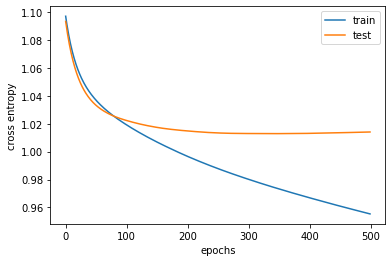

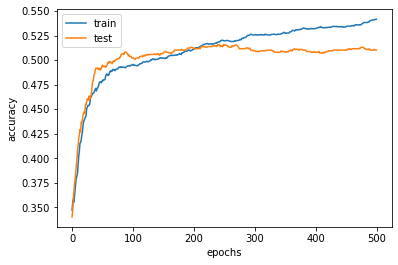

In [81]:
# plot the losses
import matplotlib.pyplot as plt

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
#OLD CODE

In [ ]:
#Gives accuracy and f1 score for using every stat possible
rfc=RandomForestClassifier()
Xr=ufc_fights[possible_stats]
yr=ufc_fights['method']

rfc.fit(Xr,yr)
accuracy = cross_val_score(rfc,Xr,yr,cv=3).mean()
precision = cross_val_score(rfc,Xr,yr,cv=3, scoring='precision_micro').mean()
recall = cross_val_score(rfc, Xr, yr, cv=3, scoring='recall_macro').mean()
print('Accuracy: '+str(accuracy),'F1 score: '+str(precision*recall/(precision+recall)))

In [ ]:
#scores a model
def model_score(dataframe,features, iloc_val = 3200):
    yyy=dataframe['method'].iloc[0:iloc_val]
    XXX=dataframe[features].iloc[0:iloc_val]
    XXXscaler = preprocessing.StandardScaler().fit(XXX)
    XXX_scaled = XXXscaler.transform(XXX) 
    rfc=RandomForestClassifier()
    return cross_val_score(rfc,XXX_scaled,yyy,cv=4).mean()
    
#CODE FOR THE GREEDY ALGORITHM FOR FEATURE SELECTION
def greedy(dataframe, features, subsetsize, iloc_val=3200):
    i=0
    best_stats=[]
    s=set(features)
    subsets=list(map(set, itertools.combinations(s, subsetsize))) #subsets of size (subsetsize)
    possible_stat_dict = {}
    scores={0:0}
    for stat_pair in subsets:
        possible_stat_dict[tuple(stat_pair)]=0
    while (i==0) or (scores[i]>scores[i-1]):
        i+=1
        for stat_pair in list(possible_stat_dict.keys()):
            stats_temp = best_stats+list(stat_pair)
            possible_stat_dict[tuple(stat_pair)]=model_score(ufc_fights,stats_temp,iloc_val)
        max_key = max(possible_stat_dict, key=possible_stat_dict.get)
        best_stats.extend(list(max_key))
        scores[i]=possible_stat_dict[max_key]
        possible_stat_dict.pop(max_key)
        print(best_stats,scores[i])
    return (best_stats[:-subsetsize], scores[i-1])

In [ ]:
#searches over all single stats for the highest scoring, then it trys to add one and sees if that scores higher
#this will keep adding stats as long as they improve the accuracy of the model
greedy(ufc_fights, possible_stats, 1)

In [ ]:
greedy(ufc_fights, possible_stats, 2)

In [ ]:
#random forest does way better for picking the method!
best_stats=['fighter_ko_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights[best_stats]
yr=ufc_fights['method']

rfc.fit(Xr,yr)
accuracy = cross_val_score(rfc,Xr,yr,cv=3).mean()
precision = cross_val_score(rfc,Xr,yr,cv=3, scoring='precision_micro').mean()
recall = cross_val_score(rfc, Xr, yr, cv=3, scoring='recall_macro').mean()
print('Accuracy: '+str(accuracy),'F1 score: '+str(precision*recall/(precision+recall)))

In [ ]:
#random forest does way better for picking the method!
best_stats=['fighter_ko_losses_diff_2', 'fighter_sub_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights[best_stats]
yr=ufc_fights['method']

rfc.fit(Xr,yr)
accuracy = cross_val_score(rfc,Xr,yr,cv=3).mean()
precision = cross_val_score(rfc,Xr,yr,cv=3, scoring='precision_micro').mean()
recall = cross_val_score(rfc, Xr, yr, cv=3, scoring='recall_macro').mean()
print('Accuracy: '+str(accuracy),'F1 score: '+str(precision*recall/(precision+recall)))

In [ ]:
#checking how the score changes with iloc value
for i in range(1,50):
    iloc_val = 100*i
    best_stats=['fighter_ko_losses_diff_2', 'fighter_sub_losses_diff_2']
    rfc=RandomForestClassifier()
    Xr=ufc_fights[best_stats].iloc[0:iloc_val]
    yr=ufc_fights['method'].iloc[0:iloc_val]

    rfc.fit(Xr,yr)
    accuracy = cross_val_score(rfc,Xr,yr,cv=3).mean()
    precision = cross_val_score(rfc,Xr,yr,cv=3, scoring='precision_micro').mean()
    recall = cross_val_score(rfc, Xr, yr, cv=3, scoring='recall_macro').mean()
    print(100*i, 'Accuracy: '+str(accuracy),'F1 score: '+str(precision*recall/(precision+recall)))

In [ ]:
#crazy... one single stat puts us at .51, higher than using every possible stat... but two gives no improvement at all

In [ ]:
num_subs = len([i for i in ufc_fights['method'] if i=='SUB'])
num_kos = len([i for i in ufc_fights['method'] if i=='KO/TKO'])
num_dec = len([i for i in ufc_fights['method'] if i=='DEC'])

In [ ]:
print('number of subs: '+str(num_subs))
print('number of kos: '+str(num_kos))
print('number of decisions: '+str(num_dec))

In [ ]:
num_fights=len(ufc_fights['method'])
print('percentage of subs: '+str(num_subs/num_fights))
print('percentage of kos: '+str(num_kos/num_fights))
print('percentage of decisions: '+str(num_dec/num_fights))

In [ ]:
# so picking DEC victory every single time would get us a score of .494. We are not really beating that by much...
# but we have a better f1 score than picking DEC every time. Having a higher f1 score is important since the 
# odds are better usually when you correctly pick KO or SUB